# ML prep & application for allrecipes.com project

Use functions imported from another file.

## Properties:
- input = pandas dataframe with all recipe data
- output = ML predictions on avg rating / clustering (could also do number of ratings & reviews)

## Workflow
1. Clean up the df<br>
    - remove (largely) empty columns<br>
    - fill NA<br>
    - fix up formats (datetime, float, remove units etc)<br><br>
1. Deal with language<br>
    - remove stopwords<br>
    - stem<br>
    - (tf-idf)<br>
    - NMF<br>
    - describe each word in terms of a few NMF components (eg n=10)<br><br>
1. One-hot-encode what's needed<br><br>
1. Predict number of stars / ratings / reviews<br>

## Import packages / setup

In [473]:
# import public things

# general / random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import ipynb
import re # for string parsing / editing
import string # for string parsing / editing
from datetime import datetime
import time
import random
from pathlib import Path
import os
import ast

# for html
import requests # for getting html off the web
from bs4 import BeautifulSoup # for parsing html
import json

# for ML
from wordcloud import WordCloud, STOPWORDS
import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# import functions from my functions file
import ipynb.fs.full.functions as funcs

# update a module if it's been edited
# (this is just going around a jupyter feature where simply re-importing doesn't do anything)
# https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
import importlib
importlib.reload(funcs)

# other useful settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

## Clean up the df

In [474]:
# input the name (which is a timestamp) of the folder for the round of interest

input_timestamp = 'joint_2021-05-11_11-28'

In [475]:
# read in the dataframe with al the recipe info from Excel file
df = pd.read_excel(f'/home/bkotryna/Allrecipes/data/{input_timestamp}/processed_recipe_data.xlsx')

# set recipe_id as index
df.set_index('recipe_id', inplace=True)

# inspect
display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            3391 non-null   object 
 1   date_published                   3391 non-null   object 
 2   description                      3391 non-null   object 
 3   avg_rating                       3391 non-null   float64
 4   ratings_no                       3391 non-null   int64  
 5   recipe_cats                      3391 non-null   object 
 6   5 stars                          3391 non-null   int64  
 7   4 stars                          3391 non-null   int64  
 8   3 stars                          3391 non-null   int64  
 9   2 stars                          3391 non-null   int64  
 10  1 star                           3391 non-null   int64  
 11  reviews_no                       3391 non-null   int64  
 12  video_present   

None

,title,date_published,description,avg_rating,ratings_no,recipe_cats,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,ingredient_names,steps_no,steps_str,steps_words_no,nutrition.calories,nutrition.carbohydrateContent,nutrition.cholesterolContent,nutrition.fatContent,nutrition.fiberContent,nutrition.proteinContent,nutrition.saturatedFatContent,nutrition.servingSize,nutrition.sodiumContent,nutrition.sugarContent,nutrition.transFatContent,nutrition.unsaturatedFatContent
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,Pavlova,2019-04-04,My grandmother's recipe from New Zealand for t...,4.520000,25,"['Dessert Recipes', 'Specialty Dessert Recipes...",18,4,1,2,0,19,0,8,0,0,0,6,"['egg whites', 'distilled white vinegar', 'col...",4,Preheat oven to 300 degrees F (150 degrees C)....,102,108.1 calories,26 g,NaN,NaN,NaN,1.4 g,NaN,NaN,21.3 mg,25.2 g,NaN,NaN
10007,Evelyn's Cornflake Cookies,1997-09-26,I got this recipe from my ex mother-in-law ...,4.000000,8,"['Dessert Recipes', 'Cookies']",4,1,2,1,0,8,0,2,0,0,0,9,"['cream cheese', 'butter', 'white sugar', 'all...",3,Cream together all ingredients except cornflak...,56,195.6 calories,24.6 g,28.1 mg,10.3 g,0.5 g,2 g,6.4 g,NaN,198.6 mg,8.9 g,NaN,NaN
10014,Hazelnut Biscotti,1997-09-25,Twice-baked cookie that can have miniature cho...,4.428571,14,"['Dessert Recipes', 'Cookies', 'Nut Cookie Rec...",9,3,1,1,0,12,0,4,0,0,0,10,"['skinned toasted hazelnuts', 'white sugar', '...",4,Preheat oven to 350 degrees F (180 degrees C)....,132,259 calories,33.1 g,44.6 mg,12.2 g,1.6 g,4.6 g,4.7 g,NaN,100 mg,15.5 g,NaN,NaN
10019,Chocolate Peanut Butter Bars II,1997-09-30,No-bake peanut butter bars.,4.627551,196,"['Dessert Recipes', 'Cookies', 'Peanut Butter ...",150,31,8,2,5,156,0,20,0,0,0,6,"['butter', 'packed brown sugar', 'vanilla extr...",3,Melt butter or margarine over low heat. Add su...,32,587.9 calories,60 g,20.3 mg,37.8 g,4.2 g,12.1 g,14.4 g,NaN,257.8 mg,52.6 g,NaN,NaN
10022,Pignoli Cookies I,1997-10-05,"They are pleasantly sweet, made with almond pa...",4.415301,183,"['World Cuisine Recipes', 'European', 'Italian']",135,20,10,5,13,146,0,14,30,18,70,5,"['almond paste', 'white sugar', 'confectioners...",4,Preheat oven to 325 degrees F (165 degrees C)....,121,100.9 calories,11.4 g,NaN,5.5 g,0.7 g,2.6 g,0.7 g,NaN,7.3 mg,6.2 g,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,German Lemon Cake,2020-06-19,This loaf cake is known in Germany as 'Zitrone...,3.796296,54,"['World Cuisine Recipes', 'European', 'German']",22,14,8,5,5,45,0,7,20,75,95,8,"['butter softened', 'white sugar', 'eggs', 'ru...",4,Preheat the oven to 350 degrees (175 degrees C...,138,391.9 calories,49.7 g,123.3 mg,19.4 g,0.4 g,3.9 g,11.6 g,NaN,153.1 mg,31.4 g,NaN,NaN
91192,French Onion Soup Gratinee,2019-04-02,About as good as it gets! This is the version ...,4.741086,1823,"['Soups, Stews and Chili Recipes', 'Soup Recip...",1493,238,55,24,13,1251,1,316,15,60,75,17,"['butter', 'salt', 'red onions thinly', 'sweet...",5,Melt butter in a large pot over medium-high he...,210,617.8 calories,39.5 g,113.9 mg,35.9 g,4.2 g,29.7 g,20.8 g,NaN,3335.7 mg,10.6 g,NaN,NaN
9524,Dutch Cookies,1999-12-08,This recipe has become a cherished family favo...,4.387097,31,"['World Cuisine Recipes', 'European', 'Dutch']",18,9,3,0,1,26,0,7,0,0,0,8,"['butter', 'shortening', 'white sugar', 'all-p...",5,Preheat oven to 350 F (175 degrees C). Cream t...,121,106.6 calories,12.5 g,6.1 mg,6.1 g,0.5 g,1 g,2.9 g,NaN,32.2 mg,7.5 g,NaN,NaN


In [476]:
# drop empty columns

# BTW could use this to get rid of specific columns:
# df.drop([''], axis=1, inplace=True)

# drop columns that are all NA
df.dropna(axis=1, how='all', inplace=True)

# re-inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          3391 non-null   object 
 1   date_published                 3391 non-null   object 
 2   description                    3391 non-null   object 
 3   avg_rating                     3391 non-null   float64
 4   ratings_no                     3391 non-null   int64  
 5   recipe_cats                    3391 non-null   object 
 6   5 stars                        3391 non-null   int64  
 7   4 stars                        3391 non-null   int64  
 8   3 stars                        3391 non-null   int64  
 9   2 stars                        3391 non-null   int64  
 10  1 star                         3391 non-null   int64  
 11  reviews_no                     3391 non-null   int64  
 12  video_present                  3391 non-null

## Dealing with publication date

In [477]:
# convert date_published from str to datetime

# first, inspect
display(type(df.iloc[0]['date_published']))

# then, convert
df['date_published'] =  pd.to_datetime(df['date_published'])

# then, re-inspect
type(df.iloc[0]['date_published'])

str

pandas._libs.tslibs.timestamps.Timestamp

In [478]:
# add recipe_age (ie time since publication) column, drop date_published column

# define what date is today (roughly)
# could use datetime.datetime.now() if wanted to have up-to-date "today", but I figure I'd rather have fixed number here atm
datetime_today = datetime(2021, 4, 27)
print(datetime_today)

# calculate recipe age
df['recipe_age'] = df['date_published'] - datetime_today
# convert recipe age to an integer number of days (I think it's always rounding down)
df['recipe_age'] = df['recipe_age'].apply(lambda x: -x.days)

# drop the original date_published column
df.drop('date_published', axis=1, inplace=True)

# inspect
display(df['recipe_age'])
display(df.info())

2021-04-27 00:00:00


recipe_id
10004     754
10007    8614
10014    8615
10019    8610
10022    8605
         ... 
87484     312
91192     756
9524     7811
9800     4684
9954     4684
Name: recipe_age, Length: 3391, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          3391 non-null   object 
 1   description                    3391 non-null   object 
 2   avg_rating                     3391 non-null   float64
 3   ratings_no                     3391 non-null   int64  
 4   recipe_cats                    3391 non-null   object 
 5   5 stars                        3391 non-null   int64  
 6   4 stars                        3391 non-null   int64  
 7   3 stars                        3391 non-null   int64  
 8   2 stars                        3391 non-null   int64  
 9   1 star                         3391 non-null   int64  
 10  reviews_no                     3391 non-null   int64  
 11  video_present                  3391 non-null   int64  
 12  photo_count                    3391 non-null

None

## Transform recipe_cats & ingredient_names columns from lists to comma-separated strings

In [479]:
# transform recipe_cats & ingredient_names columns. Each cell goes from a list into a comma-seprated string

# recipe_cats
df['recipe_cats_str'] = df['recipe_cats'].apply(lambda x: x[1:-1])
df['recipe_cats_str'] = df['recipe_cats_str'].apply(lambda x: x.replace("'", ""))
display(df['recipe_cats_str'])

# ingredient_names
df['ingredient_names_str'] = df['ingredient_names'].apply(lambda x: x[1:-1])
df['ingredient_names_str'] = df['ingredient_names_str'].apply(lambda x: x.replace("'", ""))
display(df['ingredient_names_str'])

# alternative - gives a string, rather than individual strings separated by commas, as far as I can tell
# recipes_df['ingredient_names'] = recipes_df['ingredient_names'].apply(lambda x: ', '.join([str(i) for i in x]))

recipe_id
10004    Dessert Recipes, Specialty Dessert Recipes, Pa...
10007                             Dessert Recipes, Cookies
10014    Dessert Recipes, Cookies, Nut Cookie Recipes, ...
10019    Dessert Recipes, Cookies, Peanut Butter Cookie...
10022             World Cuisine Recipes, European, Italian
                               ...                        
87484              World Cuisine Recipes, European, German
91192    Soups, Stews and Chili Recipes, Soup Recipes, ...
9524                World Cuisine Recipes, European, Dutch
9800                World Cuisine Recipes, European, Dutch
9954               World Cuisine Recipes, European, French
Name: recipe_cats_str, Length: 3391, dtype: object

recipe_id
10004    egg whites, distilled white vinegar, cold wate...
10007    cream cheese, butter, white sugar, all-purpose...
10014    skinned toasted hazelnuts, white sugar, unsalt...
10019    butter, packed brown sugar, vanilla extract, p...
10022    almond paste, white sugar, confectioners sugar...
                               ...                        
87484    butter softened, white sugar, eggs, rum, all-p...
91192    butter, salt, red onions thinly, sweet onions ...
9524     butter, shortening, white sugar, all-purpose f...
9800     butter, white sugar, all-purpose flour, cinnam...
9954     eggs, vanilla extract, salt, white sugar, all-...
Name: ingredient_names_str, Length: 3391, dtype: object

## Convert recipe category lists into columns of one-hot encoding

In [480]:
# convert recipe_cats string into list
df["recipe_cats_list"]  = df["recipe_cats"].apply(ast.literal_eval)

# could expand lists into separate columns if desired
#test_df = df['recipe_cats_list'].apply(pd.Series).add_prefix('cats_')

# extract unique values from recipe_cats
unique_values = []
for index, row in df['recipe_cats_list'].iteritems():
    for item in row:
        if item not in unique_values:
            unique_values.append(item)
display(unique_values)

# make a new cat_df for manual one-hot encoding (will append this to the master df when done)
cat_df = pd.DataFrame(columns = unique_values, index=df.index)
display(cat_df)            

['Dessert Recipes',
 'Specialty Dessert Recipes',
 'Pavlova Recipes',
 'Cookies',
 'Nut Cookie Recipes',
 'Hazelnut',
 'Peanut Butter Cookie Recipes',
 'World Cuisine Recipes',
 'European',
 'Italian',
 'Drop Cookie Recipes',
 'Filled Cookie Recipes',
 'Nut Dessert Recipes',
 'Pecan Dessert Recipes',
 'No-Bake Cookie Recipes',
 'Fruit Dessert Recipes',
 'Cherry Dessert Recipes',
 'Frostings and Icings',
 'Cookie Frosting',
 'Fruit Cookie Recipes',
 'Coconut',
 'Brownie Recipes',
 'Chocolate Brownie Recipes',
 'Bar Cookie Recipes',
 'International Cookie Recipes',
 'American Cookie Recipes',
 'Fruits and Vegetables',
 'Vegetables',
 'Squash',
 'Butter Cookie Recipes',
 'Shortbread Cookie Recipes',
 'UK and Ireland',
 'Welsh',
 'Cut-Out Cookie Recipes',
 '100+ Breakfast and Brunch Recipes',
 'Sugar Cookie Recipes',
 'Dutch',
 'Almond Dessert Recipes',
 'Spice Cookie Recipes',
 'Irish',
 'Date',
 'Apricot',
 'Scandinavian',
 'Refrigerator Cookie Recipes',
 'German',
 'Chocolate Dessert Re

,Dessert Recipes,Specialty Dessert Recipes,Pavlova Recipes,Cookies,Nut Cookie Recipes,Hazelnut,Peanut Butter Cookie Recipes,World Cuisine Recipes,European,Italian,Drop Cookie Recipes,Filled Cookie Recipes,Nut Dessert Recipes,Pecan Dessert Recipes,No-Bake Cookie Recipes,Fruit Dessert Recipes,Cherry Dessert Recipes,Frostings and Icings,Cookie Frosting,Fruit Cookie Recipes,Coconut,Brownie Recipes,Chocolate Brownie Recipes,Bar Cookie Recipes,International Cookie Recipes,American Cookie Recipes,Fruits and Vegetables,Vegetables,Squash,Butter Cookie Recipes,Shortbread Cookie Recipes,UK and Ireland,Welsh,Cut-Out Cookie Recipes,100+ Breakfast and Brunch Recipes,Sugar Cookie Recipes,Dutch,Almond Dessert Recipes,Spice Cookie Recipes,Irish,Date,Apricot,Scandinavian,Refrigerator Cookie Recipes,German,Chocolate Dessert Recipes,Milk Chocolate,Latin American,Mexican,Chocolate,Bread,Quick Bread Recipes,Liqueur Dessert Recipes,Coffee Liqueur,Thumbprint Cookie Recipes,Raisin,Chocolate Chip Cookie Recipes,Macaroon Recipes,Apple Dessert Recipes,Banana Dessert Recipes,Meat and Poultry Recipes,Pork,Sausage,Salad,100+ Pasta Salad Recipes,Vegetarian Pasta Salad Recipes,100+ Everyday Cooking Recipes,Vegetarian,Side Dishes,Appetizers and Snacks,Pasta Appetizer Recipes,Main Dish Recipes,Dumpling Recipes,Seafood,Fish,Salmon,Smoked,"Soups, Stews and Chili Recipes",Stews,Goulash Recipes,Spaghetti Pasta Salad Recipes,Side Dish,Chicken,Chicken Breast Recipes,Pasta,Sauces and Condiments Recipes,Sauce Recipes,Pasta Sauce Recipes,Tomato,Pies,No-Bake Pie Recipes,Pudding Pie Recipes,Custard and Cream Pie Recipes,Cakes,Cheesecake Recipes,Meringue Pie Recipes,Apple Pie Recipes,Strawberry Dessert Recipes,100+ Pie Crust Recipes,Crumb Crusts,Pineapple Pie,Vintage Pie Recipes,Fruit Pie Recipes,Rhubarb Pie Recipes,Blueberry Pie Recipes,Chocolate Pie Recipes,Coconut Pie Recipes,Pastry Crusts,Savory Pie Recipes,Peach Dessert Recipes,Banana Pie Recipes,Seafood Main Dish Recipes,Clams,Halibut,Canapes and Crostini Recipes,Shrimp,Shellfish,Crab,Fish Cake Recipes,Seafood Salad Recipes,Shrimp Salad Recipes,Soup Recipes,Chicken Soup Recipes,Chicken Noodle Soup Recipes,Noodle Soup Recipes,Vegetable Soup Recipes,Barley Soup Recipes,Cream Soup Recipes,Cream of Mushroom Soup Recipes,Beans and Peas,Cream of Broccoli Soup,Onion Soup Recipes,French Onion Soup Recipes,Potato Soup Recipes,Chili Recipes,Beef Chili Recipes,Cream of Potato Soup Recipes,Stuffing and Dressing Recipes,Vegetarian Stuffing and Dressing Recipes,Dips and Spreads Recipes,Cheese Dips and Spreads Recipes,Cream Cheese Spreads Recipes,Cornbread Recipes,Cranberry Dessert Recipes,Fruit Bread Recipes,Cranberry Bread Recipes,Waldorf Salad Recipes,Pecan Pie Recipes,Casseroles,Broccoli Casserole Recipes,Potato Side Dish Recipes,Spinach Casserole,Oyster Stuffing and Dressing,Pickled Egg Recipes,Dessert Salad Recipes,Jell-O® Salad,Pancake Recipes,Whole Grain Pancake Recipes,Vegetable Salad Recipes,Lasagna Recipes,Zucchini Lasagna Recipes,Vegetable,Mushrooms,Stuffed Mushroom Recipes,Asian,Indian,Chinese,Grain Side Dish Recipes,Polenta Recipes,French Toast Recipes,Salsa Recipes,Tomato Salsa Recipes,Rice,Risotto Recipes,Fruit Salad Recipes,Strawberry Salad Recipes,Broccoli Salad Recipes,Tuna Salad Recipes,Coleslaw Recipes,No Mayo,Green Salad Recipes,Romaine Lettuce Salad Recipes,Salad Dressing Recipes,Honey Dressing Recipes,Beans,Vinaigrette Dressing Recipes,Italian Pasta Salad Recipes,Spinach Salad Recipes,Asparagus Salad Recipes,Mixed Greens Salad Recipes,Avocado Salad Recipes,Sour Cream Dressing Recipes,Pork Chop Recipes,Onion,Lamb,Chops,Marinade Recipes,Stuffed Main Dish Recipes,Stuffed Cabbage,Beef,Steaks,Flank Steak Recipes,Round Steak Recipes,Pot Roast Recipes,Beef Stroganoff Recipes,Pot Pie Recipes,French,Ham,Sandwich Recipes,Pork Tenderloin Recipes,Olives,Pizza Recipes,Spinach Dip Recipes,Snacks,Cracker Recipes,Wraps and Rolls,Hummus Recipes,Tomatoes,Lemon Dessert Recipes,Broccoli Soup Recipes,Tuna,Cake Mix Cake Recipes,Y

In [481]:
# manually one-hot encode

# add 1 if recipe belongs to a particular category
for index, row in df['recipe_cats_list'].iteritems():
    for item in row:
        for col_name in cat_df.columns:
            if item == col_name:
                cat_df.at[index, col_name] = 1

display(cat_df.info())

# replace the remaining empty (NaN) cells with zeros
cat_df.fillna(0, inplace=True)
display(cat_df.info())
display(cat_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Columns: 714 entries, Dessert Recipes to Veggie
dtypes: object(714)
memory usage: 18.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Columns: 714 entries, Dessert Recipes to Veggie
dtypes: int64(714)
memory usage: 18.7 MB


None

,Dessert Recipes,Specialty Dessert Recipes,Pavlova Recipes,Cookies,Nut Cookie Recipes,Hazelnut,Peanut Butter Cookie Recipes,World Cuisine Recipes,European,Italian,Drop Cookie Recipes,Filled Cookie Recipes,Nut Dessert Recipes,Pecan Dessert Recipes,No-Bake Cookie Recipes,Fruit Dessert Recipes,Cherry Dessert Recipes,Frostings and Icings,Cookie Frosting,Fruit Cookie Recipes,Coconut,Brownie Recipes,Chocolate Brownie Recipes,Bar Cookie Recipes,International Cookie Recipes,American Cookie Recipes,Fruits and Vegetables,Vegetables,Squash,Butter Cookie Recipes,Shortbread Cookie Recipes,UK and Ireland,Welsh,Cut-Out Cookie Recipes,100+ Breakfast and Brunch Recipes,Sugar Cookie Recipes,Dutch,Almond Dessert Recipes,Spice Cookie Recipes,Irish,Date,Apricot,Scandinavian,Refrigerator Cookie Recipes,German,Chocolate Dessert Recipes,Milk Chocolate,Latin American,Mexican,Chocolate,Bread,Quick Bread Recipes,Liqueur Dessert Recipes,Coffee Liqueur,Thumbprint Cookie Recipes,Raisin,Chocolate Chip Cookie Recipes,Macaroon Recipes,Apple Dessert Recipes,Banana Dessert Recipes,Meat and Poultry Recipes,Pork,Sausage,Salad,100+ Pasta Salad Recipes,Vegetarian Pasta Salad Recipes,100+ Everyday Cooking Recipes,Vegetarian,Side Dishes,Appetizers and Snacks,Pasta Appetizer Recipes,Main Dish Recipes,Dumpling Recipes,Seafood,Fish,Salmon,Smoked,"Soups, Stews and Chili Recipes",Stews,Goulash Recipes,Spaghetti Pasta Salad Recipes,Side Dish,Chicken,Chicken Breast Recipes,Pasta,Sauces and Condiments Recipes,Sauce Recipes,Pasta Sauce Recipes,Tomato,Pies,No-Bake Pie Recipes,Pudding Pie Recipes,Custard and Cream Pie Recipes,Cakes,Cheesecake Recipes,Meringue Pie Recipes,Apple Pie Recipes,Strawberry Dessert Recipes,100+ Pie Crust Recipes,Crumb Crusts,Pineapple Pie,Vintage Pie Recipes,Fruit Pie Recipes,Rhubarb Pie Recipes,Blueberry Pie Recipes,Chocolate Pie Recipes,Coconut Pie Recipes,Pastry Crusts,Savory Pie Recipes,Peach Dessert Recipes,Banana Pie Recipes,Seafood Main Dish Recipes,Clams,Halibut,Canapes and Crostini Recipes,Shrimp,Shellfish,Crab,Fish Cake Recipes,Seafood Salad Recipes,Shrimp Salad Recipes,Soup Recipes,Chicken Soup Recipes,Chicken Noodle Soup Recipes,Noodle Soup Recipes,Vegetable Soup Recipes,Barley Soup Recipes,Cream Soup Recipes,Cream of Mushroom Soup Recipes,Beans and Peas,Cream of Broccoli Soup,Onion Soup Recipes,French Onion Soup Recipes,Potato Soup Recipes,Chili Recipes,Beef Chili Recipes,Cream of Potato Soup Recipes,Stuffing and Dressing Recipes,Vegetarian Stuffing and Dressing Recipes,Dips and Spreads Recipes,Cheese Dips and Spreads Recipes,Cream Cheese Spreads Recipes,Cornbread Recipes,Cranberry Dessert Recipes,Fruit Bread Recipes,Cranberry Bread Recipes,Waldorf Salad Recipes,Pecan Pie Recipes,Casseroles,Broccoli Casserole Recipes,Potato Side Dish Recipes,Spinach Casserole,Oyster Stuffing and Dressing,Pickled Egg Recipes,Dessert Salad Recipes,Jell-O® Salad,Pancake Recipes,Whole Grain Pancake Recipes,Vegetable Salad Recipes,Lasagna Recipes,Zucchini Lasagna Recipes,Vegetable,Mushrooms,Stuffed Mushroom Recipes,Asian,Indian,Chinese,Grain Side Dish Recipes,Polenta Recipes,French Toast Recipes,Salsa Recipes,Tomato Salsa Recipes,Rice,Risotto Recipes,Fruit Salad Recipes,Strawberry Salad Recipes,Broccoli Salad Recipes,Tuna Salad Recipes,Coleslaw Recipes,No Mayo,Green Salad Recipes,Romaine Lettuce Salad Recipes,Salad Dressing Recipes,Honey Dressing Recipes,Beans,Vinaigrette Dressing Recipes,Italian Pasta Salad Recipes,Spinach Salad Recipes,Asparagus Salad Recipes,Mixed Greens Salad Recipes,Avocado Salad Recipes,Sour Cream Dressing Recipes,Pork Chop Recipes,Onion,Lamb,Chops,Marinade Recipes,Stuffed Main Dish Recipes,Stuffed Cabbage,Beef,Steaks,Flank Steak Recipes,Round Steak Recipes,Pot Roast Recipes,Beef Stroganoff Recipes,Pot Pie Recipes,French,Ham,Sandwich Recipes,Pork Tenderloin Recipes,Olives,Pizza Recipes,Spinach Dip Recipes,Snacks,Cracker Recipes,Wraps and Rolls,Hummus Recipes,Tomatoes,Lemon Dessert Recipes,Broccoli Soup Recipes,Tuna,Cake Mix Cake Recipes,Y

## Convert nutrition specs into float (strings with calories, g, mg => float)

In [482]:
# convert nutrition specs into float (strings with calories, g, mg => float)

df = funcs.remove_units(df, 'nutrition.calories', 'calories')
df = funcs.remove_units(df, 'nutrition.carbohydrateContent', 'g')
df = funcs.remove_units(df, 'nutrition.fatContent', 'g')
df = funcs.remove_units(df, 'nutrition.fiberContent', 'g')
df = funcs.remove_units(df, 'nutrition.proteinContent', 'g')
df = funcs.remove_units(df, 'nutrition.saturatedFatContent', 'g')
df = funcs.remove_units(df, 'nutrition.cholesterolContent', 'mg')
df = funcs.remove_units(df, 'nutrition.sodiumContent', 'mg')
df = funcs.remove_units(df, 'nutrition.sugarContent', 'g')

Now removing units from column:  nutrition.calories
Now removing units from column:  nutrition.carbohydrateContent
Now removing units from column:  nutrition.fatContent
Now removing units from column:  nutrition.fiberContent
Now removing units from column:  nutrition.proteinContent
Now removing units from column:  nutrition.saturatedFatContent
Now removing units from column:  nutrition.cholesterolContent
Now removing units from column:  nutrition.sodiumContent
Now removing units from column:  nutrition.sugarContent


In [483]:
# inspect
pd.set_option('display.max_rows', 5)
display(df)

# inspect some more
pd.set_option('display.max_rows', 100)
display(df.info())

,title,description,avg_rating,ratings_no,recipe_cats,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,ingredient_names,steps_no,steps_str,steps_words_no,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,recipe_age,recipe_cats_str,ingredient_names_str,recipe_cats_list
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,Pavlova,My grandmother's recipe from New Zealand for t...,4.520000,25,"['Dessert Recipes', 'Specialty Dessert Recipes...",18,4,1,2,0,19,0,8,0,0,0,6,"['egg whites', 'distilled white vinegar', 'col...",4,Preheat oven to 300 degrees F (150 degrees C)....,102,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2,754,"Dessert Recipes, Specialty Dessert Recipes, Pa...","egg whites, distilled white vinegar, cold wate...","[Dessert Recipes, Specialty Dessert Recipes, P..."
10007,Evelyn's Cornflake Cookies,I got this recipe from my ex mother-in-law ...,4.000000,8,"['Dessert Recipes', 'Cookies']",4,1,2,1,0,8,0,2,0,0,0,9,"['cream cheese', 'butter', 'white sugar', 'all...",3,Cream together all ingredients except cornflak...,56,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9,8614,"Dessert Recipes, Cookies","cream cheese, butter, white sugar, all-purpose...","[Dessert Recipes, Cookies]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,Dutch Cinnamon Biscuits,Tender with a spicy flavor.,2.750000,4,"['World Cuisine Recipes', 'European', 'Dutch']",0,1,2,0,1,4,0,1,0,0,0,7,"['butter', 'white sugar', 'all-purpose flour',...",3,Preheat oven to 350 degrees F (175 degrees C)....,92,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4,4684,"World Cuisine Recipes, European, Dutch","butter, white sugar, all-purpose flour, cinnam...","[World Cuisine Recipes, European, Dutch]"
9954,French Butter Cakes (Madeleines),Sponge cake cookie--in shell shaped molds.,4.520635,315,"['World Cuisine Recipes', 'European', 'French']",219,62,20,7,7,247,1,137,0,0,0,8,"['eggs', 'vanilla extract', 'salt', 'white sug...",9,Preheat oven to 375 degrees F (190 degrees C)....,202,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2,4684,"World Cuisine Recipes, European, French","eggs, vanilla extract, salt, white sugar, all-...","[World Cuisine Recipes, European, French]"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

## Handle language (TF-IDF, NMF etc)

### Loop through a list of columns

In [484]:
# import things

import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF

In [485]:
# generate a master nmf_df
nmf_df = pd.DataFrame(index=df.index)

# choose columns for NMF analysis
columns_for_nmf = ['title', 'description', 'ingredient_names_str', 'steps_str']

# do NMF analysis
for col in columns_for_nmf:
    col_nmf_df = funcs.stem_make_nmf(col, df, nmf_df, n=10)
    nmf_df = pd.concat([nmf_df, col_nmf_df], axis=1)


************
Now working on column 'title':
Stemming done
vocabulary size: 2170
Tokenising done.
Most freqeunt words are:
[('chicken', 232), ('cooki', 189), ('cake', 189), ('chocol', 146), ('salad', 145)]
NMF transforming done.

***
Component 0 for title

Most important words are:
chicken : 4.985
fri : 0.305
easi : 0.266
curri : 0.217
orang : 0.186

The entry that most strongly embodies this component is:
Chicken Fried Chicken

***
Component 1 for title

Most important words are:
cooki : 3.781
butter : 0.510
oatmeal : 0.482
sugar : 0.421
peanut : 0.411

The entry that most strongly embodies this component is:
Peanut Butter Oatmeal Cookies II

***
Component 2 for title

Most important words are:
cake : 3.358
coffe : 0.291
pound : 0.256
apple : 0.224
german : 0.171

The entry that most strongly embodies this component is:
German Apple Pudding Cake

***
Component 3 for title

Most important words are:
soup : 4.085
tomato : 0.518
bean : 0.459
onion : 0.316
lentil : 0.284

The entry that m

Stemming done
vocabulary size: 1615
Tokenising done.
Most freqeunt words are:
[('salt', 1847), ('pepper', 1794), ('sugar', 1747), ('white', 1464), ('butter', 1232)]
NMF transforming done.

***
Component 0 for ingredient_names_str

Most important words are:
pepper : 9.175
salt : 3.174
onion : 2.582
bell : 2.478
black : 2.408

The entry that most strongly embodies this component is:
butter, minced white onion, minced green onions, minced carrots, minced celery, minced green bell pepper, minced red bell pepper, minced garlic, salt, black pepper, cayenne pepper, nutmeg, cumin, eggs, ketchup, cream, turkey, chicken sausage, fresh bread crumbs, butter divided, shallots minced, minced red bell pepper, minced yellow bell pepper, sprig fresh thyme, bay leaves, freshly black pepper to, cream, minced garlic, beef stock, chicken stock, roma tomatoes - seeded, ketchup, salt freshly black pepper to

***
Component 1 for ingredient_names_str

Most important words are:
white : 5.372
sugar : 3.915
water

/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF transforming done.

***
Component 0 for steps_str

Most important words are:
mix : 7.604
bowl : 5.853
mixtur : 2.748
cup : 2.142
medium : 2.126

The entry that most strongly embodies this component is:
Check your coffee mugs to make sure each one holds 1 1/2 cups water. Place dry cake mix and dry pudding mix into a large bowl and blend well with a whisk. This will be about 4 to 4 1/2 cups of dry mix and will make 8 coffee cup cake mixes. Divide mix into 8 small plastic bags (about 1/2 cup each). Place mix into a corner of each bag and tie it there with a twist tie. Make glaze mix: in a medium bowl, combine confectioners sugar with powdered flavoring mix. Divide into 8 small plastic bags and close bag with a twist tie. Attach each glaze mix to the cake mix bags with a twist tie. Place one of each bag into each cup. Attach the following instructions to each cup:  Generously spray inside of cup with cooking spray. Empty contents of cake mix packet in cup. Add 1 egg, 1 tablespoon of oi

In [486]:
nmf_df

,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002003,0.213775,0.000000,0.000000,0.000000,0.000177,0.026720,0.000000,0.000000,0.107512,0.000000,0.000000,0.270110,0.000000,0.214254,0.092713,0.000000,0.037516,0.104024,0.000000
10007,0.000000,0.245501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217664,0.000000,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.000000,0.151588,0.000000,0.117872,0.183567,0.000436,0.000000,0.130547,0.000000,0.097602,0.000000,0.000000,0.150775,0.167542,0.214087,0.000000,0.005253,0.000000,0.000000,0.000000
10014,0.000000,0.000000,0.001335,0.000000,0.000000,0.002200,0.000000,0.003675,0.000000,0.000000,0.000000,0.000000,0.000000,0.188488,0.000000,0.000000,0.000000,0.246623,0.000000,0.000000,0.000331,0.175296,0.000725,0.000000,0.211255,0.000000,0.000000,0.136231,0.001392,0.079188,0.026687,0.044289,0.246381,0.252531,0.425514,0.000000,0.059036,0.000000,0.000000,0.000000
10019,0.000000,0.050413,0.020243,0.000000,0.000000,0.013168,0.020632,0.324058,0.000841,0.000000,0.000000,0.002037,0.000000,0.000280,0.000000,0.000000,0.000000,0.031565,0.000000,0.000000,0.001128,0.025401,0.003875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372909,0.022309,0.050535,0.000000,0.012543,0.000000,0.000000,0.000000,0.000160,0.103009,0.058716
10022,0.000000,0.244277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003929,0.000389,0.007350,0.002064,0.000000,0.000000,0.019797,0.000000,0.020861,0.000000,0.278355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068134,0.068967,0.000000,0.076320,0.289827,0.556327,0.000000,0.010591,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,0.001126,0.000000,0.309126,0.001390,0.000000,0.001829,0.000204,0.000926,0.000000,0.004673,0.000000,0.000000,0.000000,0.016905,0.000000,0.029205,0.000000,0.099883,0.000000,0.012800,0.000000,0.241723,0.015408,0.000000,0.138507,0.000000,0.000000,0.000000,0.097509,0.117823,0.156667,0.063835,0.222848,0.000000,0.063940,0.000000,0.004541,0.000000,0.429399,0.000000
91192,0.000000,0.000000,0.000000,0.255730,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252846,0.017566,0.014671,0.008325,0.000000,0.002343,0.003310,0.005617,0.024116,0.014742,0.191261,0.000000,0.470919,0.237717,0.051754,0.042743,0.069477,0.004719,0.069173,0.000000,0.204023,0.353989,0.296654,0.008314,0.000000,0.082484,0.197322,0.158560,0.000000,0.423047
9524,0.000000,0.247116,0.000000,0.000526,0.000002,0.000000,0.002946,0.000000,0.000000,0.000867,0.010590,0.004822,0.266971,0.000000,0.000000,0.027915,0.027449,0.098685,0.003882,0.017921,0.005209,0.114646,0.000000,0.000000,0.202932,0.000000,0.000000,0.001894,0.000000,0.191268,0.164547,0.000000,0.074144,0.175774,0.424322,0.056557,0.000000,0.009138,0.021298,0.000000


In [487]:
# inspect output

display(df.info())
display(df.describe())

pd.set_option('display.max_rows', 5)
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

,avg_rating,ratings_no,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,steps_no,steps_words_no,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,recipe_age
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3385.000000,2909.000000,3340.000000,3267.000000,3371.000000,3254.000000,3388.000000,3355.000000,3391.000000
mean,4.198652,158.556178,105.787968,35.176644,10.368033,3.991448,3.232085,119.623120,0.083161,15.745798,18.343851,36.931584,82.878502,8.802123,3.000295,93.290770,325.123975,30.421595,69.248848,16.886886,2.433303,13.147019,6.726460,549.599469,13.101192,2236.889413
std,0.551400,496.474213,369.405531,92.585773,26.441669,10.917669,10.042452,358.697786,0.276167,51.255537,27.788726,69.313397,127.632735,3.632540,1.338008,51.851408,215.527660,22.839790,72.920589,15.243779,2.614344,13.948064,6.735404,2085.346526,15.140596,2927.469689
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,28.000000
25%,4.000000,15.000000,7.000000,4.000000,1.000000,0.000000,0.000000,12.000000,0.000000,1.000000,10.000000,8.000000,25.000000,6.000000,2.000000,59.000000,164.900000,12.800000,18.600000,6.000000,0.700000,2.700000,2.000000,110.150000,2.900000,418.000000
50%,4.333333,41.000000,22.000000,11.000000,4.000000,1.000000,1.000000,33.000000,0.000000,4.000000,15.000000,20.000000,45.000000,8.000000,3.000000,87.000000,286.600000,26.100000,49.500000,13.150000,1.600000,7.100000,4.800000,306.600000,7.100000,756.000000
75%,4.544261,112.000000,69.000000,29.000000,9.000000,4.000000,3.000000,89.000000,0.000000,11.000000,20.000000,40.000000,80.000000,11.000000,4.000000,116.000000,440.700000,43.300000,93.800000,24.100000,3.300000,21.000000,9.500000,706.925000,18.000000,1133.000000
max,5.000000,13382.000000,9796.000000,2073.000000,755.000000,373.000000,385.000000,10043.000000,1.000000,1433.000000,720.000000,1080.000000,1440.000000,33.000000,13.000000,723.000000,2020.200000,216.200000,708.900000,183.800000,25.500000,101.000000,81.600000,112558.200000,122.600000,8633.000000


,title,description,avg_rating,ratings_no,recipe_cats,5 stars,4 stars,3 stars,2 stars,1 star,reviews_no,video_present,photo_count,prepTime,cookTime,totalTime,ingredients_no,ingredient_names,steps_no,steps_str,steps_words_no,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,recipe_age,recipe_cats_str,ingredient_names_str,recipe_cats_list,stemmed
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,Pavlova,My grandmother's recipe from New Zealand for t...,4.520000,25,"['Dessert Recipes', 'Specialty Dessert Recipes...",18,4,1,2,0,19,0,8,0,0,0,6,"['egg whites', 'distilled white vinegar', 'col...",4,Preheat oven to 300 degrees F (150 degrees C)....,102,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2,754,"Dessert Recipes, Specialty Dessert Recipes, Pa...","egg whites, distilled white vinegar, cold wate...","[Dessert Recipes, Specialty Dessert Recipes, P...",Preheat oven to 300 degre F (150 degre C). Bea...
10007,Evelyn's Cornflake Cookies,I got this recipe from my ex mother-in-law ...,4.000000,8,"['Dessert Recipes', 'Cookies']",4,1,2,1,0,8,0,2,0,0,0,9,"['cream cheese', 'butter', 'white sugar', 'all...",3,Cream together all ingredients except cornflak...,56,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9,8614,"Dessert Recipes, Cookies","cream cheese, butter, white sugar, all-purpose...","[Dessert Recipes, Cookies]",Cream togeth all ingredi except cornflak and c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,Dutch Cinnamon Biscuits,Tender with a spicy flavor.,2.750000,4,"['World Cuisine Recipes', 'European', 'Dutch']",0,1,2,0,1,4,0,1,0,0,0,7,"['butter', 'white sugar', 'all-purpose flour',...",3,Preheat oven to 350 degrees F (175 degrees C)....,92,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4,4684,"World Cuisine Recipes, European, Dutch","butter, white sugar, all-purpose flour, cinnam...","[World Cuisine Recipes, European, Dutch]",Preheat oven to 350 degre F (175 degre C). Cre...
9954,French Butter Cakes (Madeleines),Sponge cake cookie--in shell shaped molds.,4.520635,315,"['World Cuisine Recipes', 'European', 'French']",219,62,20,7,7,247,1,137,0,0,0,8,"['eggs', 'vanilla extract', 'salt', 'white sug...",9,Preheat oven to 375 degrees F (190 degrees C)....,202,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2,4684,"World Cuisine Recipes, European, French","eggs, vanilla extract, salt, white sugar, all-...","[World Cuisine Recipes, European, French]",Preheat oven to 375 degre F (190 degre C). But...


# Select columns that you want to use for making predictions

In [488]:
# inspect df column names & their indeces
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

In [489]:
# choose columns to keep

# manually choose indeces to keep
selected_indeces = [2, 3, 10, 11, 12, 13, 15, 16, 18, 20, 30] + list(range(21,30))

# keep columns with the chosen indeces
df = df.iloc[:, selected_indeces]

# inspect 
df

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g
recipe_id,,,,,,,,,,,,,,,,,,,,
10004,4.520000,25,19,0,8,0,0,6,4,102,754,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2
10007,4.000000,8,8,0,2,0,0,9,3,56,8614,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,2.750000,4,4,0,1,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4
9954,4.520635,315,247,1,137,0,0,8,9,202,4684,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2


In [490]:
# append sub-df's

# append cat_df to the master df
#df = pd.concat([df, cat_df], axis=1)


# add nmf_df to the master df
df = pd.concat([df, nmf_df], axis=1)

# inspect
display(df)
display(df.info())

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,4.520000,25,19,0,8,0,0,6,4,102,754,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.203564,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.002003,0.213775,0.00000,0.000000,0.000000,0.000177,0.02672,0.000000,0.000000,0.107512,0.000000,0.000000,0.270110,0.000000,0.214254,0.092713,0.000000,0.037516,0.104024,0.000000
10007,4.000000,8,8,0,2,0,0,9,3,56,8614,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9,0.000000,0.245501,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.217664,0.000000,0.0,0.000000,0.000168,0.000000,0.0,0.000000,0.000000,0.151588,0.00000,0.117872,0.183567,0.000436,0.00000,0.130547,0.000000,0.097602,0.000000,0.000000,0.150775,0.167542,0.214087,0.000000,0.005253,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9800,2.750000,4,4,0,1,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4,0.000222,0.006029,0.009065,0.000925,0.001283,0.000000,0.009824,0.00248,0.00255,0.006339,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.203569,0.000000,0.404438,0.00000,0.001139,0.152239,0.000000,0.00000,0.000000,0.000000,0.041874,0.000000,0.009778,0.174462,0.277398,0.174019,0.000000,0.000000,0.000000,0.163276,0.000000
9954,4.520635,315,247,1,137,0,0,8,9,202,4684,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2,0.000000,0.028247,0.299870,0.007987,0.000000,0.003652,0.000000,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.004197,0.0,0.010012,0.000000,0.036878,0.0,0.000000,0.004705,0.216310,0.00982,0.000000,0.173607,0.000000,0.00000,0.000000,0.038403,0.186407,0.113653,0.089049,0.000961,0.192400,0.016707,0.000000,0.000000,0.045134,0.638559,0.000798


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

## Fill NA: Select desired numeric columns and fill NA with mean for column

In [491]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

In [492]:
# select columns where NA's should be filled with the mean value for that column
columns_to_fill = df.columns.str.startswith('nutrition')

# inspect
df.loc[:,columns_to_fill]

,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g
recipe_id,,,,,,,,,
10004,108.1,26.0,NaN,NaN,NaN,1.4,NaN,21.3,25.2
10007,195.6,24.6,28.1,10.3,0.5,2.0,6.4,198.6,8.9
...,...,...,...,...,...,...,...,...,...
9800,159.9,17.5,35.8,9.0,0.6,2.6,5.1,61.1,5.4
9954,108.8,15.3,41.2,4.7,0.2,1.6,2.7,63.3,11.2


In [493]:
# fill NA
df.loc[:,columns_to_fill] = df.loc[:,columns_to_fill].apply(lambda x: x.fillna(x.mean()),axis=0)

# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

In [494]:
# re-inspect
display(df.info())

pd.set_option('display.max_rows', 10)
display(df.describe())

pd.set_option('display.max_rows', 10)
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000
mean,4.198652,158.556178,119.623120,0.083161,15.745798,18.343851,82.878502,8.802123,3.000295,93.290770,2236.889413,325.123975,30.421595,69.248848,16.886886,2.433303,13.147019,6.726460,549.599469,13.101192,0.014998,0.016158,0.018466,0.012516,0.015736,0.016419,0.013878,0.015689,0.015757,0.020554,0.033318,0.052749,0.056955,0.040109,0.042283,0.040831,0.028078,0.042741,0.022410,0.033877,0.057010,0.081040,0.053058,0.057022,0.061841,0.041490,0.065569,0.036968,0.034017,0.053068,0.082154,0.116691,0.132375,0.045736,0.067914,0.067039,0.077404,0.070502,0.069770,0.104702
std,0.551400,496.474213,358.697786,0.276167,51.255537,27.788726,127.632735,3.632540,1.338008,51.851408,2927.469689,215.527660,22.819569,67.537895,15.128679,2.566084,13.906859,6.597902,2084.423602,15.059989,0.050414,0.059767,0.067613,0.047798,0.061969,0.061356,0.057146,0.065358,0.058798,0.056136,0.063909,0.091420,0.100826,0.087563,0.084019,0.074456,0.067675,0.073365,0.069792,0.069863,0.079887,0.109745,0.105900,0.083325,0.085753,0.089349,0.091222,0.070446,0.080588,0.088982,0.090886,0.135996,0.177587,0.140835,0.169898,0.110623,0.106849,0.099109,0.140807,0.126649
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,9.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,15.000000,12.000000,0.000000,1.000000,10.000000,25.000000,6.000000,2.000000,59.000000,418.000000,164.900000,12.800000,22.700000,6.100000,0.700000,2.800000,2.100000,110.250000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

,avg_rating,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,4.520000,25,19,0,8,0,0,6,4,102,754,108.1,26.0,69.248848,16.886886,2.433303,1.4,6.72646,21.3,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002003,0.213775,0.000000,0.000000,0.000000,0.000177,0.026720,0.000000,0.000000,0.107512,0.000000,0.000000,0.270110,0.000000,0.214254,0.092713,0.000000,0.037516,0.104024,0.000000
10007,4.000000,8,8,0,2,0,0,9,3,56,8614,195.6,24.6,28.100000,10.300000,0.500000,2.0,6.40000,198.6,8.9,0.000000,0.245501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217664,0.000000,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.000000,0.151588,0.000000,0.117872,0.183567,0.000436,0.000000,0.130547,0.000000,0.097602,0.000000,0.000000,0.150775,0.167542,0.214087,0.000000,0.005253,0.000000,0.000000,0.000000
10014,4.428571,14,12,0,4,0,0,10,4,132,8615,259.0,33.1,44.600000,12.200000,1.600000,4.6,4.70000,100.0,15.5,0.000000,0.000000,0.001335,0.000000,0.000000,0.002200,0.000000,0.003675,0.000000,0.000000,0.000000,0.000000,0.000000,0.188488,0.000000,0.000000,0.000000,0.246623,0.000000,0.000000,0.000331,0.175296,0.000725,0.000000,0.211255,0.000000,0.000000,0.136231,0.001392,0.079188,0.026687,0.044289,0.246381,0.252531,0.425514,0.000000,0.059036,0.000000,0.000000,0.000000
10019,4.627551,196,156,0,20,0,0,6,3,32,8610,587.9,60.0,20.300000,37.800000,4.200000,12.1,14.40000,257.8,52.6,0.000000,0.050413,0.020243,0.000000,0.000000,0.013168,0.020632,0.324058,0.000841,0.000000,0.000000,0.002037,0.000000,0.000280,0.000000,0.000000,0.000000,0.031565,0.000000,0.000000,0.001128,0.025401,0.003875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372909,0.022309,0.050535,0.000000,0.012543,0.000000,0.000000,0.000000,0.000160,0.103009,0.058716
10022,4.415301,183,146,0,14,30,70,5,4,121,8605,100.9,11.4,69.248848,5.500000,0.700000,2.6,0.70000,7.3,6.2,0.000000,0.244277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003929,0.000389,0.007350,0.002064,0.000000,0.000000,0.019797,0.000000,0.020861,0.000000,0.278355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068134,0.068967,0.000000,0.076320,0.289827,0.556327,0.000000,0.010591,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,3.796296,54,45,0,7,20,95,8,4,138,312,391.9,49.7,123.300000,19.400000,0.400000,3.9,11.60000,153.1,31.4,0.001126,0.000000,0.309126,0.001390,0.000000,0.001829,0.000204,0.000926,0.000000,0.004673,0.000000,0.000000,0.000000

## Should inspect the data, check for outliers / correlations / etc

## Predict avg_rating:
## 1. Use all features

## Let's do train-test split

In [495]:
# split data into train & test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'avg_rating'], df['avg_rating'], random_state=0)

In [496]:
# inspect

display(X_train)
display(y_train)

,ratings_no,reviews_no,video_present,photo_count,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25067,4,4,0,2,20,30,8,3,142,312,228.1,33.1,24.0,9.3,0.600000,3.0,3.6,166.3,17.3,0.000000,0.274091,0.000722,7.141289e-04,0.000069,0.000000,0.004783,0.000000,0.000345,0.000000,0.000000,0.000000,0.222969,0.368759,0.178593,0.137268,0.000000,0.205527,0.000000,0.000000,0.000931,0.184645,0.000000,0.000000,0.220034,0.000000,0.000000,0.018003,0.000000,0.023484,0.039390,0.098712,0.000000,0.203915,0.881969,0.000000,0.000000,0.000000,0.000000,0.000000
31592,29,25,0,4,25,50,8,2,74,1054,178.0,20.0,27.2,10.4,2.900000,3.9,5.1,334.0,5.6,0.000000,0.000411,0.000000,5.223087e-03,0.005257,0.008099,0.006741,0.002682,0.013623,0.005600,0.000000,0.000000,0.000000,0.000000,0.195767,0.000000,0.199423,0.000000,0.013011,0.000000,0.116302,0.000000,0.000000,0.084614,0.014243,0.001022,0.181391,0.007411,0.000000,0.000000,0.044603,0.571352,0.000000,0.000000,0.000000,0.007318,0.033796,0.174717,0.000000,0.245914
46719,39,28,0,5,10,45,9,3,72,418,204.0,31.5,31.1,7.2,2.500000,5.1,4.1,174.1,17.8,0.000000,0.000000,0.010638,0.000000e+00,0.000000,0.005992,0.002510,0.015173,0.000000,0.015646,0.000000,0.075954,0.000000,0.002753,0.000000,0.000000,0.000000,0.214587,0.000000,0.020970,0.000000,0.068050,0.000000,0.045314,0.035699,0.140298,0.000000,0.000000,0.009765,0.134504,0.172448,0.121600,0.386207,0.000000,0.024686,0.015409,0.000000,0.000000,0.140670,0.000000
9800,4,4,0,1,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.600000,2.6,5.1,61.1,5.4,0.000222,0.006029,0.009065,9.254710e-04,0.001283,0.000000,0.009824,0.002480,0.002550,0.006339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203569,0.000000,0.404438,0.000000,0.001139,0.152239,0.000000,0.000000,0.000000,0.000000,0.041874,0.000000,0.009778,0.174462,0.277398,0.174019,0.000000,0.000000,0.000000,0.163276,0.000000
36996,485,354,1,68,15,27,7,3,82,657,742.2,4.3,169.3,60.9,0.500000,44.3,11.1,2036.0,0.3,0.005203,0.000000,0.000000,0.000000e+00,0.006879,0.009370,0.000000,0.001475,0.008744,0.021703,0.011898,0.013927,0.020570,0.002376,0.012870,0.011276,0.013788,0.000278,0.015584,0.046806,0.073761,0.111097,0.020538,0.000000,0.015352,0.001081,0.155856,0.123190,0.083353,0.000000,0.022681,0.011640,0.043567,0.000000,0.004517,0.000000,0.371453,0.054059,0.023243,0.063517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25149,109,85,0,8,90,105,13,3,140,754,201.7,8.1,43.4,10.7,1.300000,18.5,2.6,103.2,2.6,0.000958,0.000000,0.000000,0.000000e+00,0.000000,0.004268,0.000000,0.000000,0.006568,0.028940,0.000000,0.217108,0.000000,0.000000,0.000000,0.000000,0.212985,0.000000,0.015797,0.000000,0.034250,0.000000,0.314617,0.004782,0.000000,0.021032,0.330692,0.266010

recipe_id
25067    4.750000
31592    4.275862
46719    4.487179
9800     2.750000
36996    4.750515
           ...   
25149    4.376147
48814    5.000000
26770    4.037037
39789    3.000000
42064    4.207547
Name: avg_rating, Length: 2543, dtype: float64

## Gradient boosted tree for regression

In [497]:
# try out tree predictions for avg_rating

learning_rates_broad = [1, 0.5, 0.2, 0.1, 0.05, 0.025, 0.010, 0.005, 0.001]
learning_rates_narrow = [0.024, 0.025, 0.026, 0.027, 0.028, 0.029]

for learning_rate in learning_rates_broad:
    print('\nLearning rate = {:.3f}'.format(learning_rate))
    regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, min_samples_leaf=5)
    funcs.train_and_evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    
    # High learning rates => overfitted
    # Low learning rates => underfitted


Learning rate = 1.000
Feature ratings_no: importance = 0.340
Feature photo_count: importance = 0.091
Feature reviews_no: importance = 0.037
Feature totalTime: importance = 0.026
Feature nutrition.sodiumContent in mg: importance = 0.026
Feature description_nmf_0: importance = 0.021
Feature nutrition.proteinContent in g: importance = 0.020
Feature prepTime: importance = 0.020
Feature nutrition.calories in calories: importance = 0.018
Feature nutrition.fatContent in g: importance = 0.017
Mean abs error on train = 0.117
Mean abs error on test = 0.409
Mean sq error on train = 0.023
Mean sq error on test = 0.324

Learning rate = 0.500
Feature ratings_no: importance = 0.309
Feature photo_count: importance = 0.136
Feature reviews_no: importance = 0.061
Feature totalTime: importance = 0.033
Feature nutrition.sodiumContent in mg: importance = 0.030
Feature title_nmf_7: importance = 0.023
Feature ingredient_names_str_nmf_8: importance = 0.020
Feature nutrition.proteinContent in g: importance = 0

In [498]:
# how does mean_sq_error for test compare with stdev of the test data? (Ig R^2)
y_test.describe()

count    848.000000
mean       4.197008
std        0.575475
min        0.000000
25%        4.030679
50%        4.340112
75%        4.540589
max        5.000000
Name: avg_rating, dtype: float64

## Prepare data for more regression models (Lasso, Ridge, Linear)

In [499]:
# normalise to mean=0, variance=1

from sklearn import preprocessing

linreg_features = X_train.columns

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Explore Lasso regression (ie with L1 normalisation)

In [500]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

regr = Lasso(alpha=0.03)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

reviews_no
0.038941705563051945


video_present
0.038442496233480214


title_nmf_7
-0.019318083093162904


photo_count
0.008116796738890264


steps_str_nmf_6
0.007570856209246192


totalTime
0.0016384400562041881


ratings_no
0.0


prepTime
0.0


ingredients_no
0.0


steps_no
-0.0


Mean squared error: 0.32
Coefficient of determination: 0.04


## Explore Ridge regression (ie with L2 normalisation)

In [501]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

regr = Ridge(alpha=1000000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

reviews_no
0.00024390639077816515


ratings_no
0.00023979279878421717


video_present
0.00023831148162469475


photo_count
0.00022990272263701697


title_nmf_7
-0.0001318999469920362


steps_str_nmf_6
0.00010987868436055216


totalTime
9.65869057006423e-05


ingredients_no
7.675250158745198e-05


nutrition.fatContent in g
7.420104799830183e-05


ingredient_names_str_nmf_6
7.268726654315872e-05


Mean squared error: 0.33
Coefficient of determination: 0.00


## Explore Linear Regression

In [502]:
# do linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression(normalize=True,)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

reviews_no
0.7549760747550996


ratings_no
-0.730532499601821


nutrition.calories in calories
-0.22657522098090843


nutrition.fatContent in g
0.17299498828232002


video_present
0.06018448371839905


steps_no
-0.055648836343765724


nutrition.carbohydrateContent in g
0.054479712375189206


title_nmf_7
-0.05400127043224055


steps_str_nmf_6
0.05131982265024563


ingredient_names_str_nmf_9
0.04800465052012005


Mean squared error: 0.31
Coefficient of determination: 0.06


In [503]:
# check the coeff. for one particular feature

for feature, coef in sorted_features_and_coefs:
    if feature == 'steps_str_nmf_0':
        print(feature, '\n', coef)

steps_str_nmf_0 
 -0.043125735628656674


## Predict avg_rating:
## 2. Let's experiment & drop features that seem to dominate predictions otherwise<br>(and seem confounding)

In [504]:
# let's just experiment - drop the columns that seem to dominate predictions in the Gradient Boosted tree
# (and they also seem dependent variables with the rating value, so makes sense to remove them)

df.drop(['ratings_no', 'photo_count', 'reviews_no'], axis=1, inplace = True)
df

,avg_rating,video_present,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10004,4.520000,0,0,0,6,4,102,754,108.1,26.0,69.248848,16.886886,2.433303,1.4,6.72646,21.3,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002003,0.213775,0.000000,0.000000,0.000000,0.000177,0.026720,0.000000,0.000000,0.107512,0.000000,0.000000,0.270110,0.000000,0.214254,0.092713,0.000000,0.037516,0.104024,0.000000
10007,4.000000,0,0,0,9,3,56,8614,195.6,24.6,28.100000,10.300000,0.500000,2.0,6.40000,198.6,8.9,0.000000,0.245501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217664,0.000000,0.000000,0.000000,0.000168,0.000000,0.000000,0.000000,0.000000,0.151588,0.000000,0.117872,0.183567,0.000436,0.000000,0.130547,0.000000,0.097602,0.000000,0.000000,0.150775,0.167542,0.214087,0.000000,0.005253,0.000000,0.000000,0.000000
10014,4.428571,0,0,0,10,4,132,8615,259.0,33.1,44.600000,12.200000,1.600000,4.6,4.70000,100.0,15.5,0.000000,0.000000,0.001335,0.000000,0.000000,0.002200,0.000000,0.003675,0.000000,0.000000,0.000000,0.000000,0.000000,0.188488,0.000000,0.000000,0.000000,0.246623,0.000000,0.000000,0.000331,0.175296,0.000725,0.000000,0.211255,0.000000,0.000000,0.136231,0.001392,0.079188,0.026687,0.044289,0.246381,0.252531,0.425514,0.000000,0.059036,0.000000,0.000000,0.000000
10019,4.627551,0,0,0,6,3,32,8610,587.9,60.0,20.300000,37.800000,4.200000,12.1,14.40000,257.8,52.6,0.000000,0.050413,0.020243,0.000000,0.000000,0.013168,0.020632,0.324058,0.000841,0.000000,0.000000,0.002037,0.000000,0.000280,0.000000,0.000000,0.000000,0.031565,0.000000,0.000000,0.001128,0.025401,0.003875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372909,0.022309,0.050535,0.000000,0.012543,0.000000,0.000000,0.000000,0.000160,0.103009,0.058716
10022,4.415301,0,30,70,5,4,121,8605,100.9,11.4,69.248848,5.500000,0.700000,2.6,0.70000,7.3,6.2,0.000000,0.244277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003929,0.000389,0.007350,0.002064,0.000000,0.000000,0.019797,0.000000,0.020861,0.000000,0.278355,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068134,0.068967,0.000000,0.076320,0.289827,0.556327,0.000000,0.010591,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87484,3.796296,0,20,95,8,4,138,312,391.9,49.7,123.300000,19.400000,0.400000,3.9,11.60000,153.1,31.4,0.001126,0.000000,0.309126,0.001390,0.000000,0.001829,0.000204,0.000926,0.000000,0.004673,0.000000,0.000000,0.000000,0.016905,0.000000,0.029205,0.000000,0.099883,0.000000,0.012800,0.000000,0.241723,0.015408,0.000000,0

## Let's do train-test split

In [505]:
# split data into train & test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'avg_rating'], df['avg_rating'], random_state=0)

In [506]:
# inspect

display(X_train)
display(y_train)

,video_present,prepTime,totalTime,ingredients_no,steps_no,steps_words_no,recipe_age,nutrition.calories in calories,nutrition.carbohydrateContent in g,nutrition.cholesterolContent in mg,nutrition.fatContent in g,nutrition.fiberContent in g,nutrition.proteinContent in g,nutrition.saturatedFatContent in g,nutrition.sodiumContent in mg,nutrition.sugarContent in g,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,description_nmf_0,description_nmf_1,description_nmf_2,description_nmf_3,description_nmf_4,description_nmf_5,description_nmf_6,description_nmf_7,description_nmf_8,description_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9
recipe_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
25067,0,20,30,8,3,142,312,228.1,33.1,24.0,9.3,0.600000,3.0,3.6,166.3,17.3,0.000000,0.274091,0.000722,7.141289e-04,0.000069,0.000000,0.004783,0.000000,0.000345,0.000000,0.000000,0.000000,0.222969,0.368759,0.178593,0.137268,0.000000,0.205527,0.000000,0.000000,0.000931,0.184645,0.000000,0.000000,0.220034,0.000000,0.000000,0.018003,0.000000,0.023484,0.039390,0.098712,0.000000,0.203915,0.881969,0.000000,0.000000,0.000000,0.000000,0.000000
31592,0,25,50,8,2,74,1054,178.0,20.0,27.2,10.4,2.900000,3.9,5.1,334.0,5.6,0.000000,0.000411,0.000000,5.223087e-03,0.005257,0.008099,0.006741,0.002682,0.013623,0.005600,0.000000,0.000000,0.000000,0.000000,0.195767,0.000000,0.199423,0.000000,0.013011,0.000000,0.116302,0.000000,0.000000,0.084614,0.014243,0.001022,0.181391,0.007411,0.000000,0.000000,0.044603,0.571352,0.000000,0.000000,0.000000,0.007318,0.033796,0.174717,0.000000,0.245914
46719,0,10,45,9,3,72,418,204.0,31.5,31.1,7.2,2.500000,5.1,4.1,174.1,17.8,0.000000,0.000000,0.010638,0.000000e+00,0.000000,0.005992,0.002510,0.015173,0.000000,0.015646,0.000000,0.075954,0.000000,0.002753,0.000000,0.000000,0.000000,0.214587,0.000000,0.020970,0.000000,0.068050,0.000000,0.045314,0.035699,0.140298,0.000000,0.000000,0.009765,0.134504,0.172448,0.121600,0.386207,0.000000,0.024686,0.015409,0.000000,0.000000,0.140670,0.000000
9800,0,0,0,7,3,92,4684,159.9,17.5,35.8,9.0,0.600000,2.6,5.1,61.1,5.4,0.000222,0.006029,0.009065,9.254710e-04,0.001283,0.000000,0.009824,0.002480,0.002550,0.006339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.203569,0.000000,0.404438,0.000000,0.001139,0.152239,0.000000,0.000000,0.000000,0.000000,0.041874,0.000000,0.009778,0.174462,0.277398,0.174019,0.000000,0.000000,0.000000,0.163276,0.000000
36996,1,15,27,7,3,82,657,742.2,4.3,169.3,60.9,0.500000,44.3,11.1,2036.0,0.3,0.005203,0.000000,0.000000,0.000000e+00,0.006879,0.009370,0.000000,0.001475,0.008744,0.021703,0.011898,0.013927,0.020570,0.002376,0.012870,0.011276,0.013788,0.000278,0.015584,0.046806,0.073761,0.111097,0.020538,0.000000,0.015352,0.001081,0.155856,0.123190,0.083353,0.000000,0.022681,0.011640,0.043567,0.000000,0.004517,0.000000,0.371453,0.054059,0.023243,0.063517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25149,0,90,105,13,3,140,754,201.7,8.1,43.4,10.7,1.300000,18.5,2.6,103.2,2.6,0.000958,0.000000,0.000000,0.000000e+00,0.000000,0.004268,0.000000,0.000000,0.006568,0.028940,0.000000,0.217108,0.000000,0.000000,0.000000,0.000000,0.212985,0.000000,0.015797,0.000000,0.034250,0.000000,0.314617,0.004782,0.000000,0.021032,0.330692,0.266010,0.000000,0.000000,0.046134,0.000000,0.000000,0.000000,0.000000,0.250503,0.074178,0.265856,0.0538

recipe_id
25067    4.750000
31592    4.275862
46719    4.487179
9800     2.750000
36996    4.750515
           ...   
25149    4.376147
48814    5.000000
26770    4.037037
39789    3.000000
42064    4.207547
Name: avg_rating, Length: 2543, dtype: float64

In [507]:
# try out prediction of avg_rating
# try out tree predictions

learning_rates_broad = [1, 0.5, 0.2, 0.1, 0.05, 0.025, 0.010, 0.005, 0.001]
learning_rates_narrow = [0.024, 0.025, 0.026, 0.027, 0.028, 0.029]

for learning_rate in learning_rates_broad:
    print('\nLearning rate = {:.3f}'.format(learning_rate))
    regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, min_samples_leaf=5)
    funcs.train_and_evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    
    # High learning rates => overfitted
    # Low learning rates => underfitted


Learning rate = 1.000
Feature recipe_age: importance = 0.057
Feature nutrition.proteinContent in g: importance = 0.043
Feature nutrition.sodiumContent in mg: importance = 0.039
Feature description_nmf_4: importance = 0.036
Feature video_present: importance = 0.036
Feature description_nmf_0: importance = 0.035
Feature nutrition.sugarContent in g: importance = 0.035
Feature steps_str_nmf_0: importance = 0.034
Feature nutrition.fatContent in g: importance = 0.031
Feature totalTime: importance = 0.031
Mean abs error on train = 0.152
Mean abs error on test = 0.498
Mean sq error on train = 0.039
Mean sq error on test = 0.493

Learning rate = 0.500
Feature recipe_age: importance = 0.047
Feature nutrition.sugarContent in g: importance = 0.046
Feature nutrition.sodiumContent in mg: importance = 0.045
Feature steps_str_nmf_0: importance = 0.043
Feature nutrition.carbohydrateContent in g: importance = 0.040
Feature totalTime: importance = 0.038
Feature nutrition.proteinContent in g: importance =

In [508]:
y_test.describe()

count    848.000000
mean       4.197008
std        0.575475
min        0.000000
25%        4.030679
50%        4.340112
75%        4.540589
max        5.000000
Name: avg_rating, dtype: float64

## Prepare data for more regression models (Lasso, Ridge, Linear)

In [509]:
# normalise to mean=0, variance=1

from sklearn import preprocessing

linreg_features = X_train.columns

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Explore Lasso regression (ie with L1 normalisation)

In [510]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

regr = Lasso(alpha=0.03)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

video_present
0.06309877319456556


title_nmf_7
-0.018562883478842107


steps_str_nmf_6
0.006736801564372368


totalTime
0.0018719061351091565


prepTime
0.0


ingredients_no
0.0


steps_no
-0.0


steps_words_no
0.0


recipe_age
0.0


nutrition.calories in calories
0.0


Mean squared error: 0.32
Coefficient of determination: 0.03


## Explore Ridge regression (ie with L2 normalisation)

In [511]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

regr = Ridge(alpha=1000000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

video_present
0.00023924879917429313


title_nmf_7
-0.00013189943417429788


steps_str_nmf_6
0.00010989482359521483


totalTime
9.664968900225884e-05


ingredients_no
7.681888229269455e-05


nutrition.fatContent in g
7.426296308801379e-05


ingredient_names_str_nmf_6
7.273098608458186e-05


description_nmf_7
-7.042156912892324e-05


nutrition.saturatedFatContent in g
7.027413545282242e-05


steps_str_nmf_0
-6.841564741539446e-05


Mean squared error: 0.33
Coefficient of determination: 0.00


## Explore Linear Regression

In [512]:
# do linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression(normalize=True,)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

nutrition.calories in calories
-0.23114787016561483


nutrition.fatContent in g
0.17979095697012998


video_present
0.0923490356843677


ingredient_names_str_nmf_9
0.05913697169379002


title_nmf_7
-0.05473480720052879


nutrition.carbohydrateContent in g
0.05461569784863351


steps_no
-0.052661641093078866


steps_str_nmf_6
0.04941171819645195


ingredient_names_str_nmf_3
0.04849767677927602


steps_str_nmf_0
-0.04310663026229031


Mean squared error: 0.32
Coefficient of determination: 0.04


In [513]:
# check the coeff. for one particular feature

for feature, coef in sorted_features_and_coefs:
    if feature == 'steps_str_nmf_0':
        print(feature, '\n', coef)

steps_str_nmf_0 
 -0.04310663026229031


## Clustering

## Let's see if clustering can differentiate between cake-like things and other stuff:<br>1. Use lots of features

In [514]:
# inspect column names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   video_present                       3391 non-null   int64  
 2   prepTime                            3391 non-null   int64  
 3   totalTime                           3391 non-null   int64  
 4   ingredients_no                      3391 non-null   int64  
 5   steps_no                            3391 non-null   int64  
 6   steps_words_no                      3391 non-null   int64  
 7   recipe_age                          3391 non-null   int64  
 8   nutrition.calories in calories      3391 non-null   float64
 9   nutrition.carbohydrateContent in g  3391 non-null   float64
 10  nutrition.cholesterolContent in mg  3391 non-null   float64
 11  nutrition.fatContent in g           339

In [515]:
# select column names

# ingredients_nmf_cols = [col for col in df if col.startswith('ingredient_names_str_nmf')]
nmf_cols = [col for col in df.columns if 'nmf' in col and 'description' not in col]
nutritional_features = ['nutrition.sugarContent in g', 'nutrition.fatContent in g']
selected_features = nmf_cols + nutritional_features

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title_nmf_0                  3391 non-null   float64
 1   title_nmf_1                  3391 non-null   float64
 2   title_nmf_2                  3391 non-null   float64
 3   title_nmf_3                  3391 non-null   float64
 4   title_nmf_4                  3391 non-null   float64
 5   title_nmf_5                  3391 non-null   float64
 6   title_nmf_6                  3391 non-null   float64
 7   title_nmf_7                  3391 non-null   float64
 8   title_nmf_8                  3391 non-null   float64
 9   title_nmf_9                  3391 non-null   float64
 10  ingredient_names_str_nmf_0   3391 non-null   float64
 11  ingredient_names_str_nmf_1   3391 non-null   float64
 12  ingredient_names_str_nmf_2   3391 non-null   float64
 13  ingredient_nam

None

In [516]:
# sqrt transform fat & sugar content to reduce the dynamic range

for col in nutritional_features:
    new_col = np.sqrt(df_for_cake_clust[col])
    new_col_name = f'sqrt of {col}'
    df_for_cake_clust[new_col_name] = new_col
    df_for_cake_clust.drop(col, axis=1, inplace=True)
    
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title_nmf_0                          3391 non-null   float64
 1   title_nmf_1                          3391 non-null   float64
 2   title_nmf_2                          3391 non-null   float64
 3   title_nmf_3                          3391 non-null   float64
 4   title_nmf_4                          3391 non-null   float64
 5   title_nmf_5                          3391 non-null   float64
 6   title_nmf_6                          3391 non-null   float64
 7   title_nmf_7                          3391 non-null   float64
 8   title_nmf_8                          3391 non-null   float64
 9   title_nmf_9                          3391 non-null   float64
 10  ingredient_names_str_nmf_0           3391 non-null   float64
 11  ingredient_names_str_nmf_1

<ipython-input-516-8bea79e8def7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust[new_col_name] = new_col
/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [517]:
# standardise all features (assume normal distribution; mean=0, variance=1)

display(df_for_cake_clust.describe())
df_columns = df_for_cake_clust.columns

from sklearn import preprocessing
df_for_cake_clust = preprocessing.StandardScaler().fit_transform(df_for_cake_clust)

# skleanr output is np array. make it into a pd df:
df_for_cake_clust = pd.DataFrame(data=df_for_cake_clust, columns=df_columns)

display(df_for_cake_clust.describe())

,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9,sqrt of nutrition.sugarContent in g,sqrt of nutrition.fatContent in g
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000
mean,0.014998,0.016158,0.018466,0.012516,0.015736,0.016419,0.013878,0.015689,0.015757,0.020554,0.057010,0.081040,0.053058,0.057022,0.061841,0.041490,0.065569,0.036968,0.034017,0.053068,0.082154,0.116691,0.132375,0.045736,0.067914,0.067039,0.077404,0.070502,0.069770,0.104702,3.108001,3.700924
std,0.050414,0.059767,0.067613,0.047798,0.061969,0.061356,0.057146,0.065358,0.058798,0.056136,0.079887,0.109745,0.105900,0.083325,0.085753,0.089349,0.091222,0.070446,0.080588,0.088982,0.090886,0.135996,0.177587,0.140835,0.169898,0.110623,0.106849,0.099109,0.140807,0.126649,1.855408,1.786333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.732051,2.469818
50%,0.000005,0.000000,0.000000,0.000000,0.000000,0.000613,0.000000,0.000000,0.000000,0.000738,0.014867,0.012135,0.000000,0.016749,0.016508,0.000561,0.013371,0.000000,0.000000,0.005504,0.059322,0.089366,0.015098,0.000000,0.000873,0.015285,0.032210,0.026055,0.007016,0.051345,2.683282,3.660601
75%,0.002296,0.001107,0.002806,0.002926,0.003720,0.007130,0.003661,0.001671,0.005447,0.013126,0.097982,0.153226,0.029660,0.089371,0.126879,0.016564,0.109083,0.018220,0.031468,0.066571,0.127616,0.194975,0.269735,0.028212,0.043970,0.092356,0.116584,0.104750,0.066233,0.181664,4.224922,4.878524
max,0.402227,0.332910,0.326834,0.280462,0.334176,0.346938,0.366505,0.388939,0.581435,0.472475,0.859987,0.766488,1.051659,0.577922,0.456577,0.925067,0.527079,0.532454,0.955205,0.567423,1.285970,0.842874,0.912617,4.060424,1.039562,1.009580,0.799832,0.570314,1.081114,0.813771,11.072488,13.557286


,title_nmf_0,title_nmf_1,title_nmf_2,title_nmf_3,title_nmf_4,title_nmf_5,title_nmf_6,title_nmf_7,title_nmf_8,title_nmf_9,ingredient_names_str_nmf_0,ingredient_names_str_nmf_1,ingredient_names_str_nmf_2,ingredient_names_str_nmf_3,ingredient_names_str_nmf_4,ingredient_names_str_nmf_5,ingredient_names_str_nmf_6,ingredient_names_str_nmf_7,ingredient_names_str_nmf_8,ingredient_names_str_nmf_9,steps_str_nmf_0,steps_str_nmf_1,steps_str_nmf_2,steps_str_nmf_3,steps_str_nmf_4,steps_str_nmf_5,steps_str_nmf_6,steps_str_nmf_7,steps_str_nmf_8,steps_str_nmf_9,sqrt of nutrition.sugarContent in g,sqrt of nutrition.fatContent in g
count,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03
mean,4.989619e-17,5.276915e-17,8.588431e-16,6.502425e-16,-1.168010e-16,-5.868368e-16,-1.094319e-15,1.281021e-15,1.089924e-16,2.278724e-16,1.357118e-15,-3.819482e-16,1.595156e-15,5.331100e-16,-5.332737e-16,4.066998e-16,-1.990413e-15,-7.255247e-17,-1.154848e-15,3.272522e-15,1.046871e-16,2.600806e-16,-4.419938e-17,-6.851232e-16,-1.581257e-15,4.976523e-17,8.712190e-16,-3.492242e-16,1.628633e-15,2.731718e-15,-1.570142e-16,4.100066e-16
std,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00
min,-2.975459e-01,-2.703952e-01,-2.731542e-01,-2.618852e-01,-2.539790e-01,-2.676504e-01,-2.428933e-01,-2.400875e-01,-2.680196e-01,-3.661890e-01,-7.137404e-01,-7.385473e-01,-5.010917e-01,-6.844301e-01,-7.212625e-01,-4.644258e-01,-7.188855e-01,-5.248472e-01,-4.221749e-01,-5.964724e-01,-9.040518e-01,-8.581721e-01,-7.455220e-01,-3.247971e-01,-3.997924e-01,-6.061014e-01,-7.245314e-01,-7.114623e-01,-4.955767e-01,-8.268288e-01,-1.675350e+00,-2.072105e+00
25%,-2.975459e-01,-2.703952e-01,-2.731542e-01,-2.618852e-01,-2.539790e-01,-2.676504e-01,-2.428933e-01,-2.400875e-01,-2.680196e-01,-3.661890e-01,-7.137404e-01,-7.385473e-01,-5.010917e-01,-6.844301e-01,-7.212625e-01,-4.644258e-01,-7.188855e-01,-5.248472e-01,-4.221749e-01,-5.964724e-01,-8.663087e-01,-8.581721e-01,-7.455220e-01,-3.247971e-01,-3.997924e-01,-6.061014e-01,-7.245314e-01,-7.114623e-01,-4.955767e-01,-8.268288e-01,-7.416980e-01,-6.892826e-01
50%,-2.974548e-01,-2.703952e-01,-2.731542e-01,-2.618852e-01,-2.539790e-01,-2.576583e-01,-2.428933e-01,-2.400875e-01,-2.680196e-01,-3.530401e-01,-5.276172e-01,-6.279611e-01,-5.010917e-01,-4.833898e-01,-5.287292e-01,-4.581459e-01,-5.722864e-01,-5.248472e-01,-4.221749e-01,-5.346064e-01,-2.512464e-01,-2.009579e-01,-6.604937e-01,-3.247971e-01,-3.946507e-01,-4.679100e-01,-4.230339e-01,-4.485365e-01,-4.457437e-01,-4.213536e-01,-2.289424e-01,-2.257661e-02
75%,-2.520026e-01,-2.518686e-01,-2.316485e-01,-2.006614e-01,-1.939423e-01,-1.514185e-01,-1.788254e-01,-2.145129e-01,-1.753690e-01,-1.323270e-01,5.129451e-01,6.578562e-01,-2.209802e-01,3.882877e-01,7.585402e-01,-2.790129e-01,4.770922e-01,-2.661763e-01,-3.163651e-02,1.517746e-01,5.002844e-01,5.757174e-01,7.735925e-01,-1.244496e-01,-1.409516e-01,2.288934e-01,3.667470e-01,3.456086e-01,-2.512764e-02,6.077709e-01,6.020702e-01,6.593248e-01
max,7.682050e+00,5.300524e+00,4.561451e+00,5.606665e+00,5.139473e+00,5.387724e+00,6.171556e+00,5.711682e+00,9.622175e+00,8.051594e+00,1.005286e+01,6.246743e+00,9.431015e+00,6.252328e+00,4.603855e+00,9.890462e+00,5.059941e+00,7.034573e+00,1.143245e+01,5.781277e+00,1.324724e+01,5.340516e+00,4.394230e+00,2.85104

In [518]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [519]:
# do agglomerative clustering

# from sklearn.cluster import AgglomerativeClustering

# clusterer = AgglomerativeClustering(n_clusters=2)
# cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [520]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments

In [521]:
# check cluster centres

clusterer.cluster_centers_

array([[-0.28085898,  0.63192466,  0.60609907, -0.24629491, -0.23291667,
        -0.18844357,  0.38003087,  0.56007597, -0.03654266, -0.26571124,
        -0.67914556,  0.81848825, -0.40135189, -0.30717939,  0.92765295,
        -0.35453553, -0.56532929,  0.34775439, -0.13172935,  1.15809277,
         0.38480943,  0.07270876,  0.17789053,  0.39265607,  0.81022735,
        -0.20248108, -0.60049517, -0.59990554,  0.92422588, -0.5187647 ,
         0.78516548, -0.16151606],
       [ 0.10882711, -0.24485788, -0.23485099,  0.09543424,  0.09025044,
         0.07301803, -0.14725419, -0.21701798,  0.01415953,  0.10295767,
         0.26315501, -0.31714745,  0.15551565,  0.11902573, -0.35944654,
         0.13737526,  0.21905353, -0.13474771,  0.05104243, -0.44873726,
        -0.14910578, -0.02817316, -0.06892894, -0.15214619, -0.31394652,
         0.07845727,  0.23267959,  0.23245112, -0.35811862,  0.20101071,
        -0.30423556,  0.06258417]])

In [522]:
# choose columns to plot (too many to plot all)

# don't plot the cluster label
columns_to_plot = [col for col in df_for_cake_clust.columns if col != 'cluster_label']

# don't plot nmf components beyond the first 5
columns_to_plot = [col for col in columns_to_plot if all(item not in col for item in ['5', '6', '7', '8', '9'])]
display(columns_to_plot)

# check how many plots this would give us
n_plots = int(len(columns_to_plot) * (len(columns_to_plot) - 1) / 2)
display(f'Number of plots: {n_plots}')

['title_nmf_0',
 'title_nmf_1',
 'title_nmf_2',
 'title_nmf_3',
 'title_nmf_4',
 'ingredient_names_str_nmf_0',
 'ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_2',
 'ingredient_names_str_nmf_3',
 'ingredient_names_str_nmf_4',
 'steps_str_nmf_0',
 'steps_str_nmf_1',
 'steps_str_nmf_2',
 'steps_str_nmf_3',
 'steps_str_nmf_4',
 'sqrt of nutrition.sugarContent in g',
 'sqrt of nutrition.fatContent in g']

'Number of plots: 136'

In [523]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

1    2445
0     946
Name: cluster_label, dtype: int64

In [524]:
# which cluster is dominating

if df_for_cake_clust['cluster_label'].sum() <= (len(df_for_cake_clust['cluster_label']) / 2):
    dominant_cluster = 0
else:
    dominant_cluster = 1
    
print(dominant_cluster)

1


In [525]:
# let's explore what the clusters may reperesent => make scatter plots
# check all combinations of axes
# use subplots

In [526]:
# set up subplot numbers for plt

n_plots_per_row = 4
print(n_plots_per_row)

# number of columns = n_plots / n_plots_per_row and round up
n_plot_columns = n_plots // n_plots_per_row + (n_plots % n_plots_per_row > 0)
print(n_plot_columns)

4
34


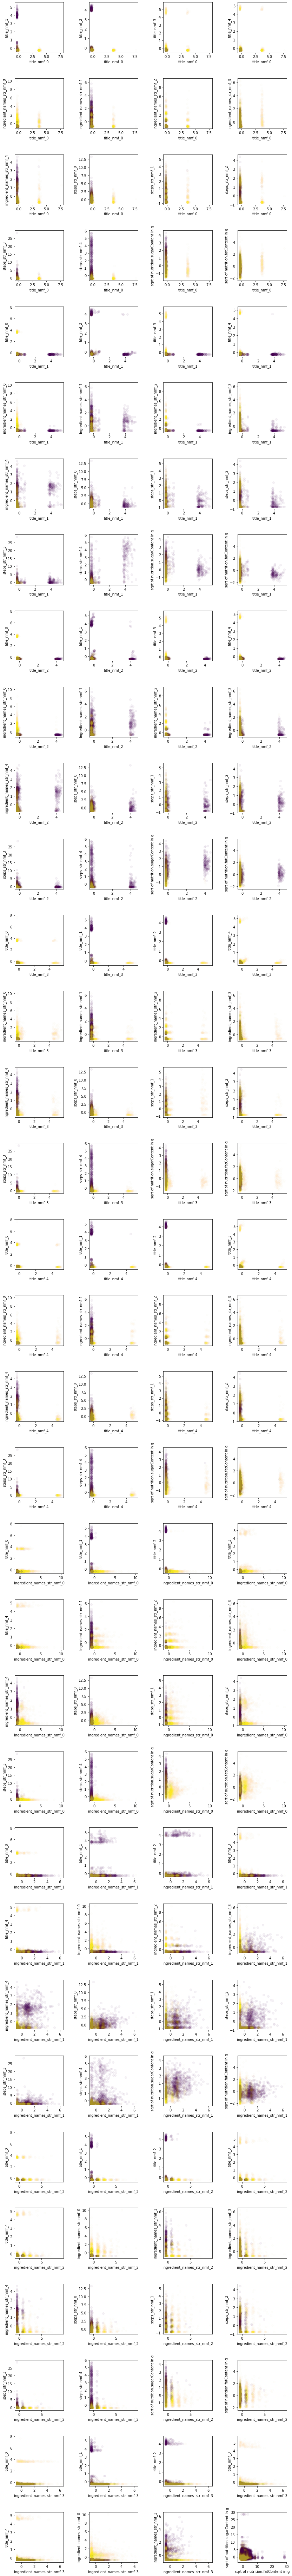

In [527]:
# get plotting

fig, axs = plt.subplots(n_plot_columns, n_plots_per_row, figsize=(3*n_plots_per_row, 3*n_plot_columns), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.7)

axs = axs.ravel()

import matplotlib.pyplot as plt


axis_i = 0
# loop over columns
for col1 in columns_to_plot:
    x = df_for_cake_clust[col1].tolist()
    
    for col2 in columns_to_plot:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()
            
            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                
                # adjust transparency: make the dominant cluster more transparent
                # (Ig fishy, but else can be hard to see)
                if u == dominant_cluster:
                    alpha = 0.01
                else:
                    alpha = 0.05
                axs[axis_i].scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

                axs[axis_i].set_xlabel(f'{col1}')
                axs[axis_i].set_ylabel(f'{col2}')
                # plt.legend(bbox_to_anchor=(1.4, 1))
             
                # show legend for the last plot - how??
                # if axis_i == (n_plots - 1):
                    
                       
            # don't want to overshoot, otherwise jupyter shows an unsightly error
            # (that doesn't actually do anything bad, just doesn't look nice)
            if axis_i < (n_plots - 1):
                axis_i += 1

plt.tight_layout()
plt.show()

## Let's see if clustering can differentiate between cake-like things and other stuff:<br>2. Use only the "cakey" features

In [528]:
# select column names

# cakey nmf features
nmf_cols = ['title_nmf_1', 'title_nmf_2', 'title_nmf_6', 'title_nmf_7',
           'ingredient_names_str_nmf_1', 'ingredient_names_str_nmf_4', 'ingredient_names_str_nmf_9',
           'steps_str_nmf_4', 'steps_str_nmf_8']
nutritional_features = ['nutrition.sugarContent in g', 'nutrition.fatContent in g']
selected_features = nmf_cols + nutritional_features

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title_nmf_1                  3391 non-null   float64
 1   title_nmf_2                  3391 non-null   float64
 2   title_nmf_6                  3391 non-null   float64
 3   title_nmf_7                  3391 non-null   float64
 4   ingredient_names_str_nmf_1   3391 non-null   float64
 5   ingredient_names_str_nmf_4   3391 non-null   float64
 6   ingredient_names_str_nmf_9   3391 non-null   float64
 7   steps_str_nmf_4              3391 non-null   float64
 8   steps_str_nmf_8              3391 non-null   float64
 9   nutrition.sugarContent in g  3391 non-null   float64
 10  nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(11)
memory usage: 477.9 KB


None

In [529]:
# sqrt transform fat & sugar content to reduce the dynamic range

for col in nutritional_features:
    new_col = np.sqrt(df_for_cake_clust[col])
    new_col_name = f'sqrt of {col}'
    df_for_cake_clust[new_col_name] = new_col
    df_for_cake_clust.drop(col, axis=1, inplace=True)
    
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title_nmf_1                          3391 non-null   float64
 1   title_nmf_2                          3391 non-null   float64
 2   title_nmf_6                          3391 non-null   float64
 3   title_nmf_7                          3391 non-null   float64
 4   ingredient_names_str_nmf_1           3391 non-null   float64
 5   ingredient_names_str_nmf_4           3391 non-null   float64
 6   ingredient_names_str_nmf_9           3391 non-null   float64
 7   steps_str_nmf_4                      3391 non-null   float64
 8   steps_str_nmf_8                      3391 non-null   float64
 9   sqrt of nutrition.sugarContent in g  3391 non-null   float64
 10  sqrt of nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(11)
memory usag

<ipython-input-529-8bea79e8def7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust[new_col_name] = new_col
/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [530]:
# standardise all features (assume normal distribution; mean=0, variance=1)

display(df_for_cake_clust.describe())
df_columns = df_for_cake_clust.columns

from sklearn import preprocessing
df_for_cake_clust = preprocessing.StandardScaler().fit_transform(df_for_cake_clust)

# skleanr output is np array. make it into a pd df:
df_for_cake_clust = pd.DataFrame(data=df_for_cake_clust, columns=df_columns)

display(df_for_cake_clust.describe())

,title_nmf_1,title_nmf_2,title_nmf_6,title_nmf_7,ingredient_names_str_nmf_1,ingredient_names_str_nmf_4,ingredient_names_str_nmf_9,steps_str_nmf_4,steps_str_nmf_8,sqrt of nutrition.sugarContent in g,sqrt of nutrition.fatContent in g
count,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000,3391.000000
mean,0.016158,0.018466,0.013878,0.015689,0.081040,0.061841,0.053068,0.067914,0.069770,3.108001,3.700924
std,0.059767,0.067613,0.057146,0.065358,0.109745,0.085753,0.088982,0.169898,0.140807,1.855408,1.786333
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.732051,2.469818
50%,0.000000,0.000000,0.000000,0.000000,0.012135,0.016508,0.005504,0.000873,0.007016,2.683282,3.660601
75%,0.001107,0.002806,0.003661,0.001671,0.153226,0.126879,0.066571,0.043970,0.066233,4.224922,4.878524
max,0.332910,0.326834,0.366505,0.388939,0.766488,0.456577,0.567423,1.039562,1.081114,11.072488,13.557286


,title_nmf_1,title_nmf_2,title_nmf_6,title_nmf_7,ingredient_names_str_nmf_1,ingredient_names_str_nmf_4,ingredient_names_str_nmf_9,steps_str_nmf_4,steps_str_nmf_8,sqrt of nutrition.sugarContent in g,sqrt of nutrition.fatContent in g
count,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03
mean,5.276915e-17,8.588431e-16,-1.094319e-15,1.281021e-15,-3.819482e-16,-5.332737e-16,3.272522e-15,-1.581257e-15,1.628633e-15,-1.570142e-16,4.100066e-16
std,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00
min,-2.703952e-01,-2.731542e-01,-2.428933e-01,-2.400875e-01,-7.385473e-01,-7.212625e-01,-5.964724e-01,-3.997924e-01,-4.955767e-01,-1.675350e+00,-2.072105e+00
25%,-2.703952e-01,-2.731542e-01,-2.428933e-01,-2.400875e-01,-7.385473e-01,-7.212625e-01,-5.964724e-01,-3.997924e-01,-4.955767e-01,-7.416980e-01,-6.892826e-01
50%,-2.703952e-01,-2.731542e-01,-2.428933e-01,-2.400875e-01,-6.279611e-01,-5.287292e-01,-5.346064e-01,-3.946507e-01,-4.457437e-01,-2.289424e-01,-2.257661e-02
75%,-2.518686e-01,-2.316485e-01,-1.788254e-01,-2.145129e-01,6.578562e-01,7.585402e-01,1.517746e-01,-1.409516e-01,-2.512764e-02,6.020702e-01,6.593248e-01
max,5.300524e+00,4.561451e+00,6.171556e+00,5.711682e+00,6.246743e+00,4.603855e+00,5.781277e+00,5.719865e+00,7.183564e+00,4.293213e+00,5.518464e+00


In [531]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [532]:
# do agglomerative clustering

# from sklearn.cluster import AgglomerativeClustering

# clusterer = AgglomerativeClustering(n_clusters=2)
# cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [533]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments

In [534]:
# check cluster centres

clusterer.cluster_centers_

array([[-0.2344442 , -0.22667848, -0.0649292 , -0.18754004, -0.2581871 ,
        -0.31183715, -0.3773161 , -0.28293579, -0.31853711, -0.21959272,
         0.02898081],
       [ 0.88685381,  0.85747769,  0.2456137 ,  0.70942509,  0.97666829,
         1.1796153 ,  1.42730857,  1.07028742,  1.20495982,  0.83067375,
        -0.1096284 ]])

In [535]:
# choose columns to plot

# don't plot the cluster label
columns_to_plot = [col for col in df_for_cake_clust.columns if col != 'cluster_label']

display(columns_to_plot)

# check how many plots this would give us
n_plots = int(len(columns_to_plot) * (len(columns_to_plot) - 1) / 2)
display(f'Number of plots: {n_plots}')

['title_nmf_1',
 'title_nmf_2',
 'title_nmf_6',
 'title_nmf_7',
 'ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_4',
 'ingredient_names_str_nmf_9',
 'steps_str_nmf_4',
 'steps_str_nmf_8',
 'sqrt of nutrition.sugarContent in g',
 'sqrt of nutrition.fatContent in g']

'Number of plots: 55'

In [536]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

0    2682
1     709
Name: cluster_label, dtype: int64

In [537]:
# which cluster is dominating

if df_for_cake_clust['cluster_label'].sum() <= (len(df_for_cake_clust['cluster_label']) / 2):
    dominant_cluster = 0
else:
    dominant_cluster = 1
    
print(dominant_cluster)

0


In [538]:
# let's explore what the clusters may reperesent => make scatter plots
# check all combinations of axes
# use subplots

In [539]:
# set up subplot numbers for plt

n_plots_per_row = 4
print(n_plots_per_row)

# number of columns = n_plots / n_plots_per_row and round up
n_plot_columns = n_plots // n_plots_per_row + (n_plots % n_plots_per_row > 0)
print(n_plot_columns)

4
14


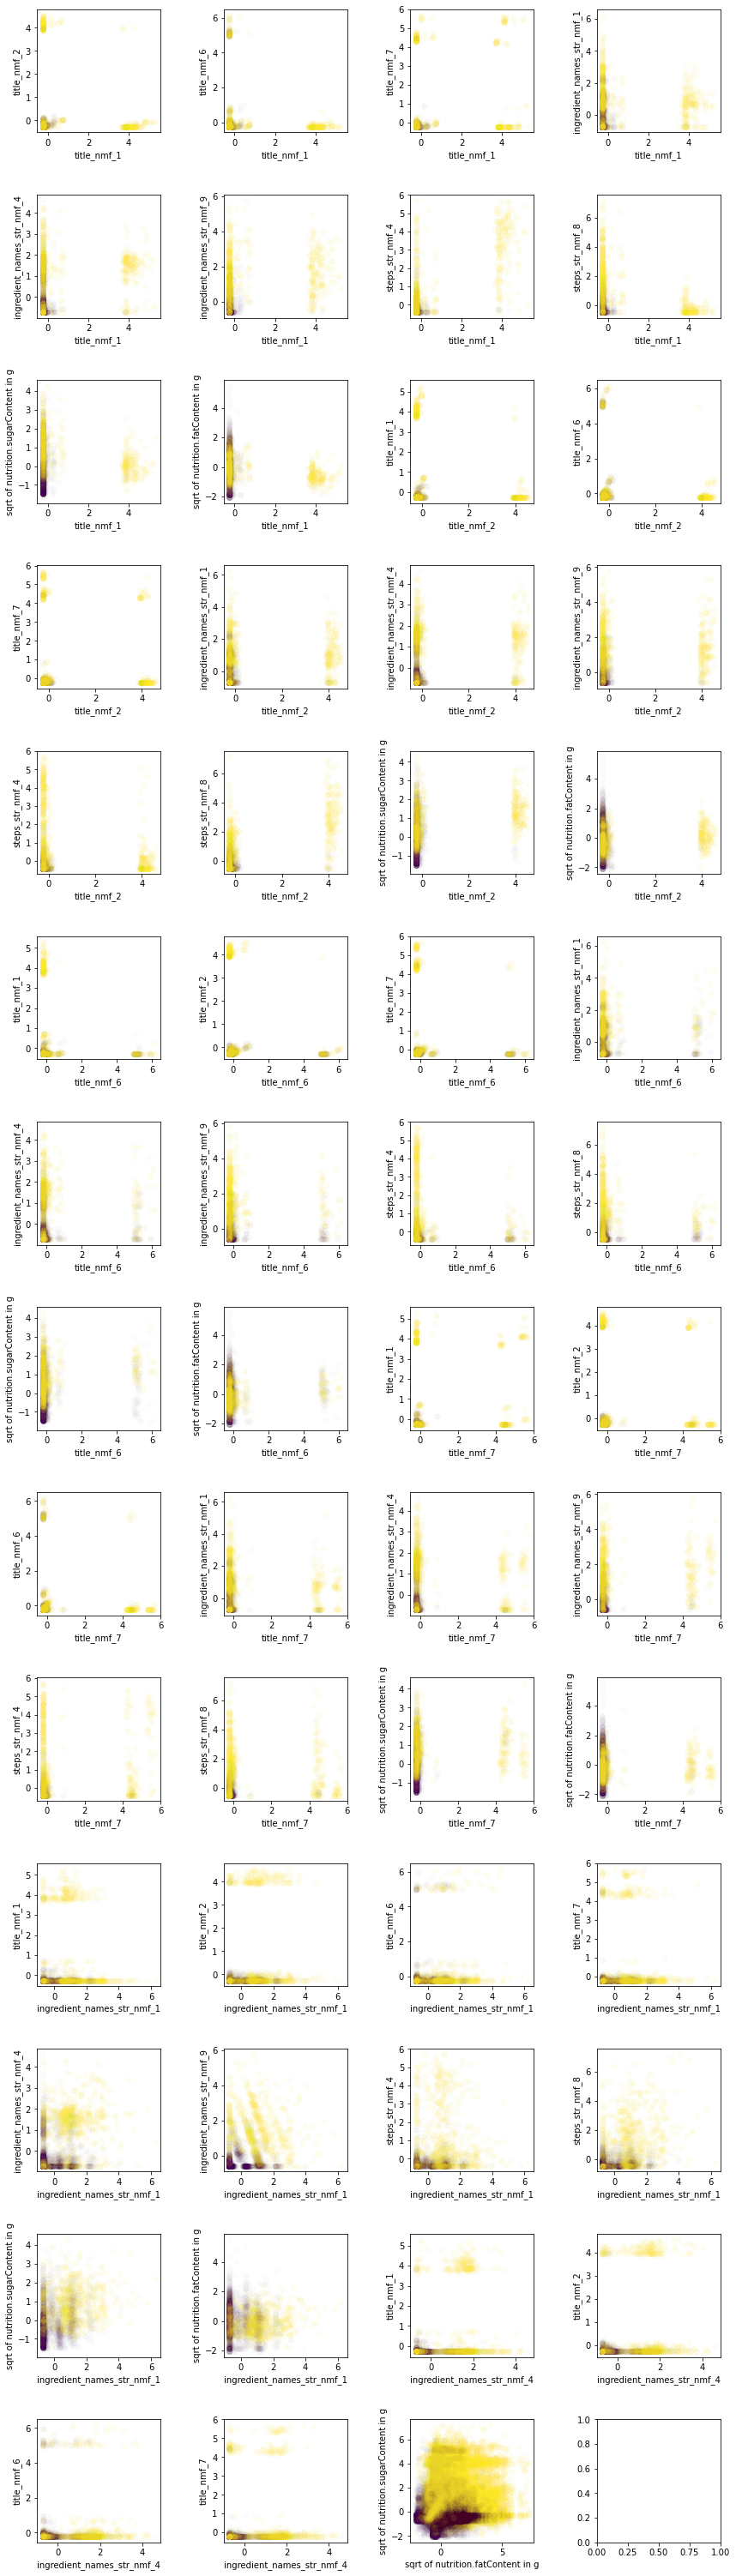

In [540]:
# get plotting

fig, axs = plt.subplots(n_plot_columns, n_plots_per_row, figsize=(3*n_plots_per_row, 3*n_plot_columns), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.7)

axs = axs.ravel()

import matplotlib.pyplot as plt


axis_i = 0
# loop over columns
for col1 in columns_to_plot:
    x = df_for_cake_clust[col1].tolist()
    
    for col2 in columns_to_plot:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()
            
            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                
                # adjust transparency: make the dominant cluster more transparent
                # (Ig fishy, but else can be hard to see)
                if u == dominant_cluster:
                    alpha = 0.01
                else:
                    alpha = 0.05
                axs[axis_i].scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

                axs[axis_i].set_xlabel(f'{col1}')
                axs[axis_i].set_ylabel(f'{col2}')
                # plt.legend(bbox_to_anchor=(1.4, 1))
             
                # show legend for the last plot - how??
                # if axis_i == (n_plots - 1):
                    
                       
            # don't want to overshoot, otherwise jupyter shows an unsightly error
            # (that doesn't actually do anything bad, just doesn't look nice)
            if axis_i < (n_plots - 1):
                axis_i += 1

plt.tight_layout()
plt.show()

### Let's see if clustering can differentiate between cake-like things and other stuff:<br>3. Use only a couple (cakey) features

In [541]:
# select column names

# cakey nmf features
nmf_cols = ['ingredient_names_str_nmf_1', 'ingredient_names_str_nmf_4']
nutritional_features = ['nutrition.sugarContent in g', 'nutrition.fatContent in g']
selected_features = nmf_cols + nutritional_features

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ingredient_names_str_nmf_1   3391 non-null   float64
 1   ingredient_names_str_nmf_4   3391 non-null   float64
 2   nutrition.sugarContent in g  3391 non-null   float64
 3   nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(4)
memory usage: 292.5 KB


None

In [542]:
# sqrt transform fat & sugar content to reduce the dynamic range

for col in nutritional_features:
    new_col = np.sqrt(df_for_cake_clust[col])
    new_col_name = f'sqrt of {col}'
    df_for_cake_clust[new_col_name] = new_col
    df_for_cake_clust.drop(col, axis=1, inplace=True)
    
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ingredient_names_str_nmf_1           3391 non-null   float64
 1   ingredient_names_str_nmf_4           3391 non-null   float64
 2   sqrt of nutrition.sugarContent in g  3391 non-null   float64
 3   sqrt of nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(4)
memory usage: 292.5 KB


<ipython-input-542-8bea79e8def7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust[new_col_name] = new_col
/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [543]:
# standardise all features (assume normal distribution; mean=0, variance=1)

display(df_for_cake_clust.describe())
df_columns = df_for_cake_clust.columns

from sklearn import preprocessing
df_for_cake_clust = preprocessing.StandardScaler().fit_transform(df_for_cake_clust)

# skleanr output is np array. make it into a pd df:
df_for_cake_clust = pd.DataFrame(data=df_for_cake_clust, columns=df_columns)

display(df_for_cake_clust.describe())

,ingredient_names_str_nmf_1,ingredient_names_str_nmf_4,sqrt of nutrition.sugarContent in g,sqrt of nutrition.fatContent in g
count,3391.000000,3391.000000,3391.000000,3391.000000
mean,0.081040,0.061841,3.108001,3.700924
std,0.109745,0.085753,1.855408,1.786333
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.732051,2.469818
50%,0.012135,0.016508,2.683282,3.660601
75%,0.153226,0.126879,4.224922,4.878524
max,0.766488,0.456577,11.072488,13.557286


,ingredient_names_str_nmf_1,ingredient_names_str_nmf_4,sqrt of nutrition.sugarContent in g,sqrt of nutrition.fatContent in g
count,3.391000e+03,3.391000e+03,3.391000e+03,3.391000e+03
mean,-3.819482e-16,-5.332737e-16,-1.570142e-16,4.100066e-16
std,1.000147e+00,1.000147e+00,1.000147e+00,1.000147e+00
min,-7.385473e-01,-7.212625e-01,-1.675350e+00,-2.072105e+00
25%,-7.385473e-01,-7.212625e-01,-7.416980e-01,-6.892826e-01
50%,-6.279611e-01,-5.287292e-01,-2.289424e-01,-2.257661e-02
75%,6.578562e-01,7.585402e-01,6.020702e-01,6.593248e-01
max,6.246743e+00,4.603855e+00,4.293213e+00,5.518464e+00


In [544]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [545]:
# do agglomerative clustering

# from sklearn.cluster import AgglomerativeClustering

# clusterer = AgglomerativeClustering(n_clusters=2)
# cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [546]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments

In [547]:
# check cluster centres

clusterer.cluster_centers_

array([[-0.4944312 , -0.36309288, -0.33626922,  0.08418621],
       [ 1.12862417,  0.82882189,  0.76759228, -0.1921695 ]])

In [548]:
# choose columns to plot

# don't plot the cluster label
columns_to_plot = [col for col in df_for_cake_clust.columns if col != 'cluster_label']

display(columns_to_plot)

# check how many plots this would give us
n_plots = int(len(columns_to_plot) * (len(columns_to_plot) - 1) / 2)
display(f'Number of plots: {n_plots}')

['ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_4',
 'sqrt of nutrition.sugarContent in g',
 'sqrt of nutrition.fatContent in g']

'Number of plots: 6'

In [549]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

0    2359
1    1032
Name: cluster_label, dtype: int64

In [550]:
# which cluster is dominating

if df_for_cake_clust['cluster_label'].sum() <= (len(df_for_cake_clust['cluster_label']) / 2):
    dominant_cluster = 0
else:
    dominant_cluster = 1
    
print(dominant_cluster)

0


In [551]:
# let's explore what the clusters may reperesent => make scatter plots
# check all combinations of axes
# use subplots

In [552]:
# set up subplot numbers for plt

n_plots_per_row = 4
print(n_plots_per_row)

# number of columns = n_plots / n_plots_per_row and round up
n_plot_columns = n_plots // n_plots_per_row + (n_plots % n_plots_per_row > 0)
print(n_plot_columns)

4
2


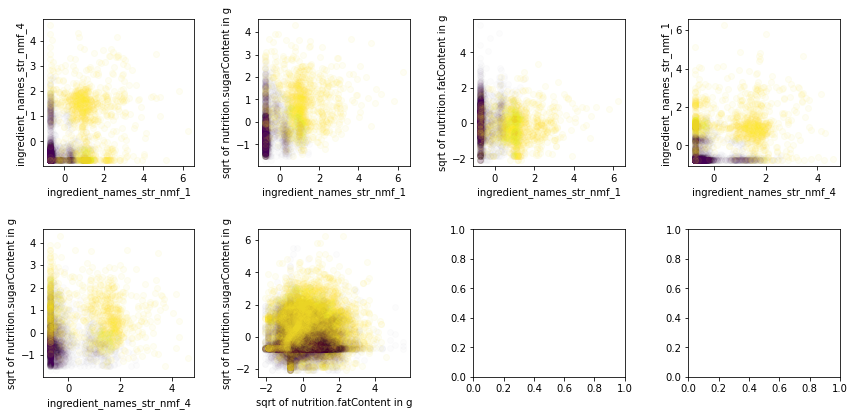

In [553]:
# get plotting

fig, axs = plt.subplots(n_plot_columns, n_plots_per_row, figsize=(3*n_plots_per_row, 3*n_plot_columns), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.7)

axs = axs.ravel()

import matplotlib.pyplot as plt


axis_i = 0
# loop over columns
for col1 in columns_to_plot:
    x = df_for_cake_clust[col1].tolist()
    
    for col2 in columns_to_plot:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()
            
            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                
                # adjust transparency: make the dominant cluster more transparent
                # (Ig fishy, but else can be hard to see)
                if u == dominant_cluster:
                    alpha = 0.01
                else:
                    alpha = 0.05
                axs[axis_i].scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

                axs[axis_i].set_xlabel(f'{col1}')
                axs[axis_i].set_ylabel(f'{col2}')
                # plt.legend(bbox_to_anchor=(1.4, 1))
             
                # show legend for the last plot - how??
                # if axis_i == (n_plots - 1):
                    
                       
            # don't want to overshoot, otherwise jupyter shows an unsightly error
            # (that doesn't actually do anything bad, just doesn't look nice)
            if axis_i < (n_plots - 1):
                axis_i += 1

plt.tight_layout()
plt.show()

## Random optional leftovers

In [554]:
df_for_cake_clust.columns

Index(['ingredient_names_str_nmf_1', 'ingredient_names_str_nmf_4',
       'sqrt of nutrition.sugarContent in g',
       'sqrt of nutrition.fatContent in g', 'cluster_label'],
      dtype='object')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


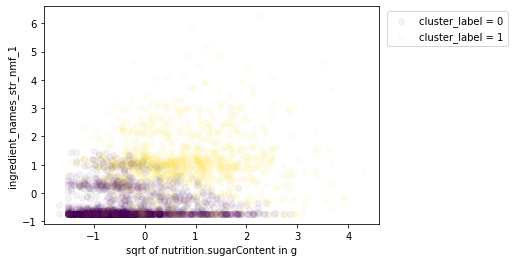

In [555]:
# without subplots

import matplotlib.pyplot as plt

# nmf_1 is the cakey component
x_value = 'sqrt of nutrition.sugarContent in g'
y_value = 'ingredient_names_str_nmf_1' 

x = df_for_cake_clust[x_value].tolist()
y = df_for_cake_clust[y_value].tolist()
classes = df_for_cake_clust['cluster_label'].tolist()

unique = list(set(classes))
colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    if u ==1:
        alpha = 0.05
    else:
        alpha = 0.05
    plt.scatter(xi, yi, c=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)
    
plt.xlabel(f'{x_value}')
plt.ylabel(f'{y_value}')
plt.legend(bbox_to_anchor=(1.4, 1))

plt.show()

In [556]:
# check an individual plot

import matplotlib.pyplot as plt

x_value = 'ingredient_names_str_nmf_0'
y_value = 'ingredient_names_str_nmf_1' # nmf_1 is the cakey component

#df_for_cake_clust.plot.scatter(x_value, y_value, c=df_for_cake_clust['cluster_label'], a=0.1)

fig = plt.figure()
plt.scatter(x = df_for_cake_clust[x_value],
           y = df_for_cake_clust[y_value],
           alpha = 0.1,
           c = df_for_cake_clust['cluster_label'])
plt.xlabel(f'{x_value}')
plt.ylabel(f'{y_value}')
plt.show()

KeyError: 'ingredient_names_str_nmf_0'

<Figure size 432x288 with 0 Axes>

## Conclusions<br>

1. <b>Predicting avg_rating</b>:
    1. Gradient Boosted Regression Tree works well
        1. Best learning_rate = 0.1:
            - mean_abs_error = 0.301
            - mean_sq_error on test = 0.192<br>
        BTW standard deviation of avg_rating on test is 0.575
        <br><br>
        1. Key features (three dominant ones):
            1. ratings_no = 0.35
            1. photo_count = 0.201
            1. reviews_no = 0.093<br>
            => These seem like they're confounded with avg_rating<br>
            eg maybe people add more photos for nice recipes
            <br><br>
    1. If we exclude the top three features mentioned above:
        1. Best learning_rate = 0.05:
            - mean_abs_error on test = 0.365
            - mean_sq_error on test = 0.313
            - BTW standard deviation of avg_rating on test is 0.575<br>
        => much higher than our mean_sq_error
        <br><br>
        1. Key features vary depending on the learning rate. For this case only two are somewhat dominating:
            1. video_present = 0.118
            1. recipe_age = 0.080
        <br><br>
1. <b>Clustering</b>:
    1. Want to separate out cakey vs savoury foods
    <br><br>
    1. Use k-means clustering with n=2 clusters
        - Choose various combinations of features to be used in this
        - sqrt transform nutritional data
        - standardise all data (mean=0, var=1)
    <br><br>
    1. Visualise clusters by plotting all xy axes combinations
        - Don't see nice separation on any of the plots